# Rat OGD VAMPIRE Data Analysis

Teng-Jui Lin

Created: 2022-05-21

Edited: 2022-10-04

Objective: Analyze data obtained from VAMPIRE analysis for rat OGD model.

## Import VAMPIRE analysis data

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import vampire as vp
from sklearn import manifold

In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
vp.plot.set_plot_style()

In [3]:
output_path = r'/Users/tlin/Files/2019-2023 University of Washington/_nance-lab/research-data/microfiber/rat-ogd/4-vampire-analysis-data'
model_path = os.path.join(output_path, 'model_otsu_(50_5_29)__otsu.pickle')
vampire_model = vp.util.read_pickle(model_path)
property_path = os.path.join(output_path, 'apply-properties_otsu_on_otsu_(50_5_29)__.pickle')
apply_properties_df = vp.util.read_pickle(property_path)

## Data processing

### Label experimental metadata

In [4]:
apply_properties_df.head()

filename  image_id  label  centroid-y  \
0  4-59_3_40x_thalamus_5_yen_thresh.tif         0      1   20.604520   
1  4-59_3_40x_thalamus_5_yen_thresh.tif         0      2   47.279570   
2  4-59_3_40x_thalamus_5_yen_thresh.tif         0      3   96.621711   
3  4-59_3_40x_thalamus_5_yen_thresh.tif         0      4  170.970339   
4  4-59_3_40x_thalamus_5_yen_thresh.tif         0      5  183.589235   

   centroid-x  area  bbox_area  convex_area  filled_area   perimeter  ...  \
0  384.011299   177        399          348          177  118.669048  ...   
1  218.630824   279        374          304          279   66.941125  ...   
2  213.996711   304        441          329          304   67.491378  ...   
3  382.063559   236        342          263          236   59.976659  ...   
4  322.218130   353        483          365          353   68.183766  ...   

   eccentricity  solidity    extent  \
0      0.588975  0.508621  0.443609   
1      0.572534  0.917763  0.745989   
2      0.284848  0.924012  0.689342   
3      0.379336  0.897338  0.690058   
4      0.361220  0.967123  0.730849   

                                         raw_contour  circularity  \
0  [[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 16, ...     0.157946   
1  [[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,...     0.782399   
2  [[10, 11, 12, 13, 14, 15, 15, 16, 17, 17, 17, ...     0.838662   
3  [[11, 12, 13, 14, 15, 16, 17, 17, 18, 18, 17, ...     0.824437   
4  [[13, 14, 15, 16, 17, 18, 19, 19, 19, 20, 20, ...     0.954163   

   aspect_ratio                                 normalized_contour  \
0      1.237392  [0.6015685298868785, 0.34081709532506077, 0.15...   
1      1.219689  [1.2043363430967842, 1.1744566647049817, 1.060...   
2      1.043218  [0.9835869688517785, 0.947284338016464, 0.9879...   
3      1.080779  [1.1026768364431876, 0.951599072960979, 0.8496...   
4      1.072408  [1.08371138991751, 1.0340129626520027, 0.99242...   

   cluster_id plot_cluster_id  distance_to_centroid  
0           0               1              0.725366  
1           2               3              0.420993  
2           2               3              0.396199  
3           2               3              0.481080  
4           2               3              0.362356  

[5 rows x 25 columns]

In [5]:
def label_df(properties_df, id_df, target_props, search_prop='filename'):
    """
    properties_df : DataFrame
        Contains "filename" column
    id_df : DataFrame
        Contains columns listed in `properties` and "regex" column.
    target_props : list
        List of property(s) to be added. Must match column name in `id_df`.
    """
    properties_df = properties_df.copy()
    properties_df[target_props] = np.nan
    for i in range(id_df['regex'].size):
        mask = properties_df[search_prop].astype(str).str.contains(id_df['regex'][i])
        properties_df.loc[mask, target_props] = id_df.iloc[i, :][target_props].values
    return properties_df

In [6]:
data_label_path = r'/Users/tlin/Files/2019-2023 University of Washington/_nance-lab/research-data/microfiber/rat-ogd/3-data-labels'

In [7]:
slice_id_df = pd.read_excel(os.path.join(data_label_path, 'slice-labels.xlsx'))
slice_id_df['regex'] = slice_id_df['slice_id'] + '_'
slice_id_df.head()

slice_id treatment treatment_color     regex
0   4-50-4        NC         #757575   4-50-4_
1   4-50-7        NC         #757575   4-50-7_
2  4-50-10        NC         #757575  4-50-10_
3  4-50-15        NC         #757575  4-50-15_
4   4-56-1  OGD 0.5h         #00ACC1   4-56-1_

In [8]:
region_id_df = pd.read_excel(os.path.join(data_label_path, 'region-labels.xlsx'))
region_id_df.head()

id       region        regex region_color
0       cortex       Cortex       cortex      #A0C8FA
1     thalamus     Thalamus     thalamus      #F04341
2  hippocampus  Hippocampus  hippocampus      #F0CA07

In [9]:
threshold_id_df = pd.read_excel(os.path.join(data_label_path, 'threshold-labels.xlsx'))
threshold_id_df.head()

id threshold regex
0  otsu      Otsu  otsu
1   yen       Yen   yen

In [10]:
apply_properties_df = label_df(apply_properties_df, slice_id_df, ['slice_id', 'treatment', 'treatment_color'])
apply_properties_df = label_df(apply_properties_df, region_id_df, ['region', 'region_color'])
apply_properties_df = label_df(apply_properties_df, threshold_id_df, ['threshold'])

### Label cluster coloring

In [11]:
# create color labels
from matplotlib.colors import to_hex
color_id_df = pd.DataFrame({
    'plot_cluster_id': [1, 2, 3, 4, 5],
    'cluster_color': [to_hex(plt.get_cmap('twilight')(np.linspace(0.1, 0.9, 5))[i]) for i in range(5)],
})
color_id_df['regex'] = color_id_df['plot_cluster_id'].astype(str)

In [12]:
apply_properties_df = label_df(apply_properties_df, color_id_df, ['cluster_color'], 'plot_cluster_id')

In [13]:
label_colors = apply_properties_df.cluster_color.values
label_colors

array(['#a6bfca', '#2f1436', '#2f1436', ..., '#d0b39e', '#a6bfca',
       '#2f1436'], dtype=object)

### Save labeled DataFrame

In [14]:
apply_properties_df.head()

filename  image_id  label  centroid-y  \
0  4-59_3_40x_thalamus_5_yen_thresh.tif         0      1   20.604520   
1  4-59_3_40x_thalamus_5_yen_thresh.tif         0      2   47.279570   
2  4-59_3_40x_thalamus_5_yen_thresh.tif         0      3   96.621711   
3  4-59_3_40x_thalamus_5_yen_thresh.tif         0      4  170.970339   
4  4-59_3_40x_thalamus_5_yen_thresh.tif         0      5  183.589235   

   centroid-x  area  bbox_area  convex_area  filled_area   perimeter  ...  \
0  384.011299   177        399          348          177  118.669048  ...   
1  218.630824   279        374          304          279   66.941125  ...   
2  213.996711   304        441          329          304   67.491378  ...   
3  382.063559   236        342          263          236   59.976659  ...   
4  322.218130   353        483          365          353   68.183766  ...   

   cluster_id  plot_cluster_id  distance_to_centroid  slice_id  \
0           0                1              0.725366    4-59_3   
1           2                3              0.420993    4-59_3   
2           2                3              0.396199    4-59_3   
3           2                3              0.481080    4-59_3   
4           2                3              0.362356    4-59_3   

        treatment  treatment_color    region  region_color threshold  \
0  OGD 0.5h + AZO          #FDD835  Thalamus       #F04341       Yen   
1  OGD 0.5h + AZO          #FDD835  Thalamus       #F04341       Yen   
2  OGD 0.5h + AZO          #FDD835  Thalamus       #F04341       Yen   
3  OGD 0.5h + AZO          #FDD835  Thalamus       #F04341       Yen   
4  OGD 0.5h + AZO          #FDD835  Thalamus       #F04341       Yen   

   cluster_color  
0        #a6bfca  
1        #2f1436  
2        #2f1436  
3        #2f1436  
4        #2f1436  

[5 rows x 32 columns]

In [15]:
vp.util.write_pickle(os.path.join(output_path, 'labeled-apply-properties_otsu_on_otsu_(50_5_29)__.pickle'), apply_properties_df)

## Visualization of data

### Number of microglia in each group

<AxesSubplot:>

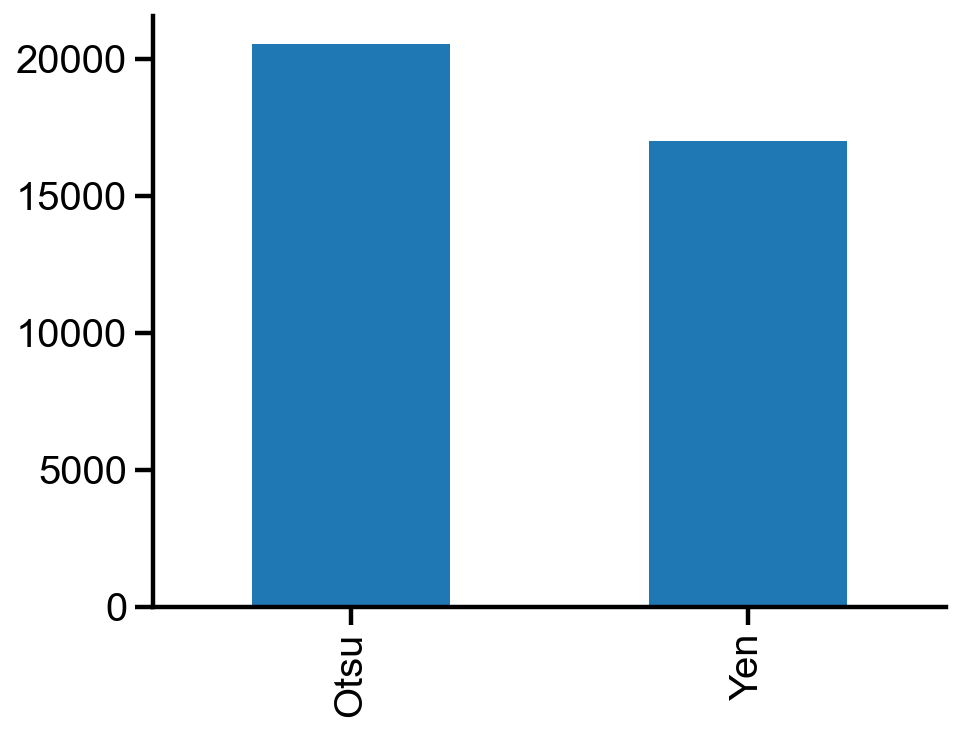

In [16]:
apply_properties_df['threshold'].value_counts().plot(kind='bar')

In [17]:
otsu_properties_df = apply_properties_df[apply_properties_df['threshold'] == 'Otsu']

<AxesSubplot:>

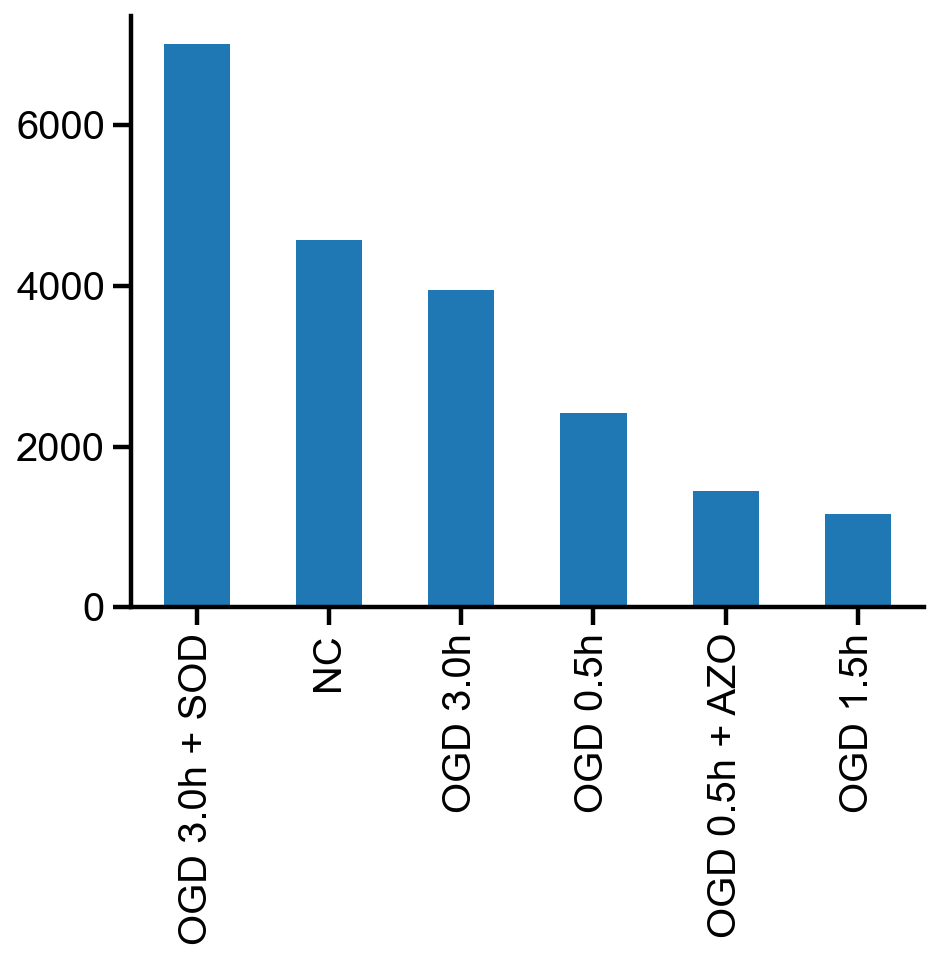

In [18]:
otsu_properties_df['treatment'].value_counts().plot(kind='bar')

<AxesSubplot:>

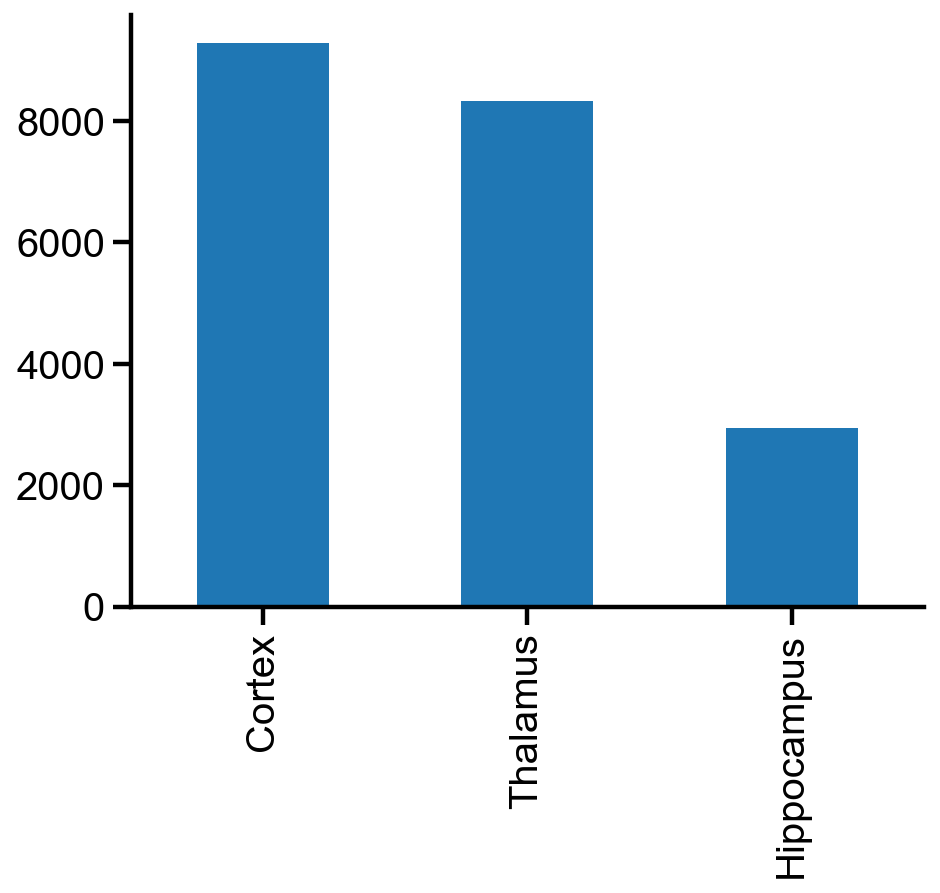

In [19]:
otsu_properties_df['region'].value_counts().plot(kind='bar')

<AxesSubplot:>

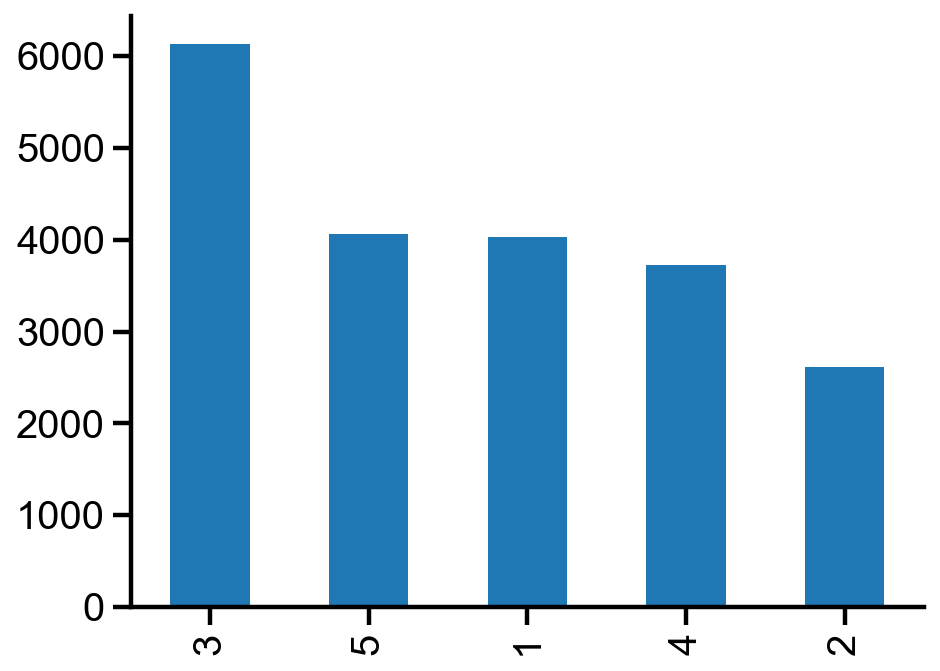

In [20]:
otsu_properties_df['plot_cluster_id'].value_counts().plot(kind='bar')  # shape mode distribution

### Creating DataFrames for GraphPad Prism Visualization

The resulting DataFrames are saved into csv that can be imported to GraphPad Prism for statistical analysis and visualization.

#### Categorical scatterplot of (morphological parameter) vs. (category)

In [112]:
reshaped_data_output = r'/Users/tlin/Files/2019-2023 University of Washington/_nance-lab/research-data/microfiber/rat-ogd/5-reshaped-data'
properties = ['area', 'perimeter', 'circularity', 'aspect_ratio', 'solidity', 'eccentricity', 'extent', 'distance_to_centroid']

In [113]:
def get_categorical_df(input_df, feature, category):
    """
    Create DataFrame for GraphPad Prism "column table" visualization of categorical scatter plots.
    Numerical feature vs. catagorical variable.
    
    input_df : DataFrame
        Contains `feature` and `category` columns.
    feature : str
        Name of numerical column to be used on y-axis.
    category : str
        Name of categorical column to be used on x-axis.
    """
    category_items = np.unique(input_df[category])
    data = [input_df[(input_df[category] == i)]
            [feature].reset_index(drop=True) 
            for i in category_items]
    df = pd.concat(data, axis=1)
    df.columns = category_items
    return df

In [114]:
# categorical scatterplot of (morphological parameter) vs. (category)
# one plot for each (morphological parameter)
for prop in properties:
    get_categorical_df(
        otsu_properties_df, 
        prop, 
        'plot_cluster_id'
    ).to_csv(
        os.path.join(reshaped_data_output, rf'cat-scat_{prop}-vs-cluster-_all_treatment_all_regions.csv'), 
        index=False
    )

#### Categorical scatterplot of (morphological parameter) vs. (category) with (controlled category)

In [24]:
def get_controlled_categorical_dfs(input_df, feature, category, controlled_category):
    """
    Create DataFrames for GraphPad Prism "column table" visualization of grouped categorical scatter plots.
    Numerical feature vs. catagorical variable with one categorical variable controlled.
    
    input_df : DataFrame
        Contains `feature` and `category` columns.
    feature : str
        Name of numerical column to be used on y-axis.
    category : str
        Name of categorical column to be used on x-axis.
    controlled_category : str
        Name of controlled categorical column to be used for subplots.
    """
    category_items = np.unique(input_df[category])
    controlled_category_items = np.unique(input_df[controlled_category])
    dfs = []
    for controlled_category_item in controlled_category_items:
        data = [
            input_df[
                (input_df[category] == i)
            ][
                input_df[(input_df[category] == i)][controlled_category] == controlled_category_item
            ][feature].reset_index(drop=True) 
            for i in category_items
        ]
        df = pd.concat(data, axis=1)
        df.columns = category_items
        dfs.append(df)
    return dfs

In [25]:
# categorical scatterplots of (morphological parameter) vs. (category) with (controlled category)
for prop in properties:
    get_controlled_categorical_dfs(otsu_properties_df, prop, 'region', 'plot_cluster_id')

#### Heatmap of (morphological parameter) with (category) vs. (controlled category)

In [26]:
def get_heatmap_df(input_df, feature, category, controlled_category, statistics='median'):
    """
    Create DataFrame for GraphPad Prism "contingency tables" visualization of heatmap.
    Categorical variable vs. catagorical variable of heatmap of numerical feature.
    
    input_df : DataFrame
        Contains `feature`, `category`, and `controlled_category` columns.
    feature : str
        Name of numerical column to be used on y-axis.
    category : str
        Name of categorical column to be used on x-axis.
    controlled_category : str
        Name of controlled categorical column to be used for subplots.
    statistics : str, optional
        Statistical parameter of interest. Default "median".
    """
    return pd.pivot_table(input_df.groupby(
        by=[category, controlled_category]).agg(statistics),
        values=feature,
        index=[category],
        columns=[controlled_category]
    )

In [27]:
get_heatmap_df(otsu_properties_df, prop, 'region', 'plot_cluster_id')

plot_cluster_id         1         2         3         4         5
region                                                           
Cortex           0.779444  0.886852  0.702221  0.810706  0.791635
Hippocampus      0.801966  0.875040  0.782354  0.786824  0.789132
Thalamus         0.774880  0.885546  0.693953  0.814291  0.786691

The resulting DataFrame can be used for heatmap visualization in both GraphPad Prism and Python. Here, we demonstrate visualization using Python.

### Population trend of morphological parameters

#### Treatment vs. cluster

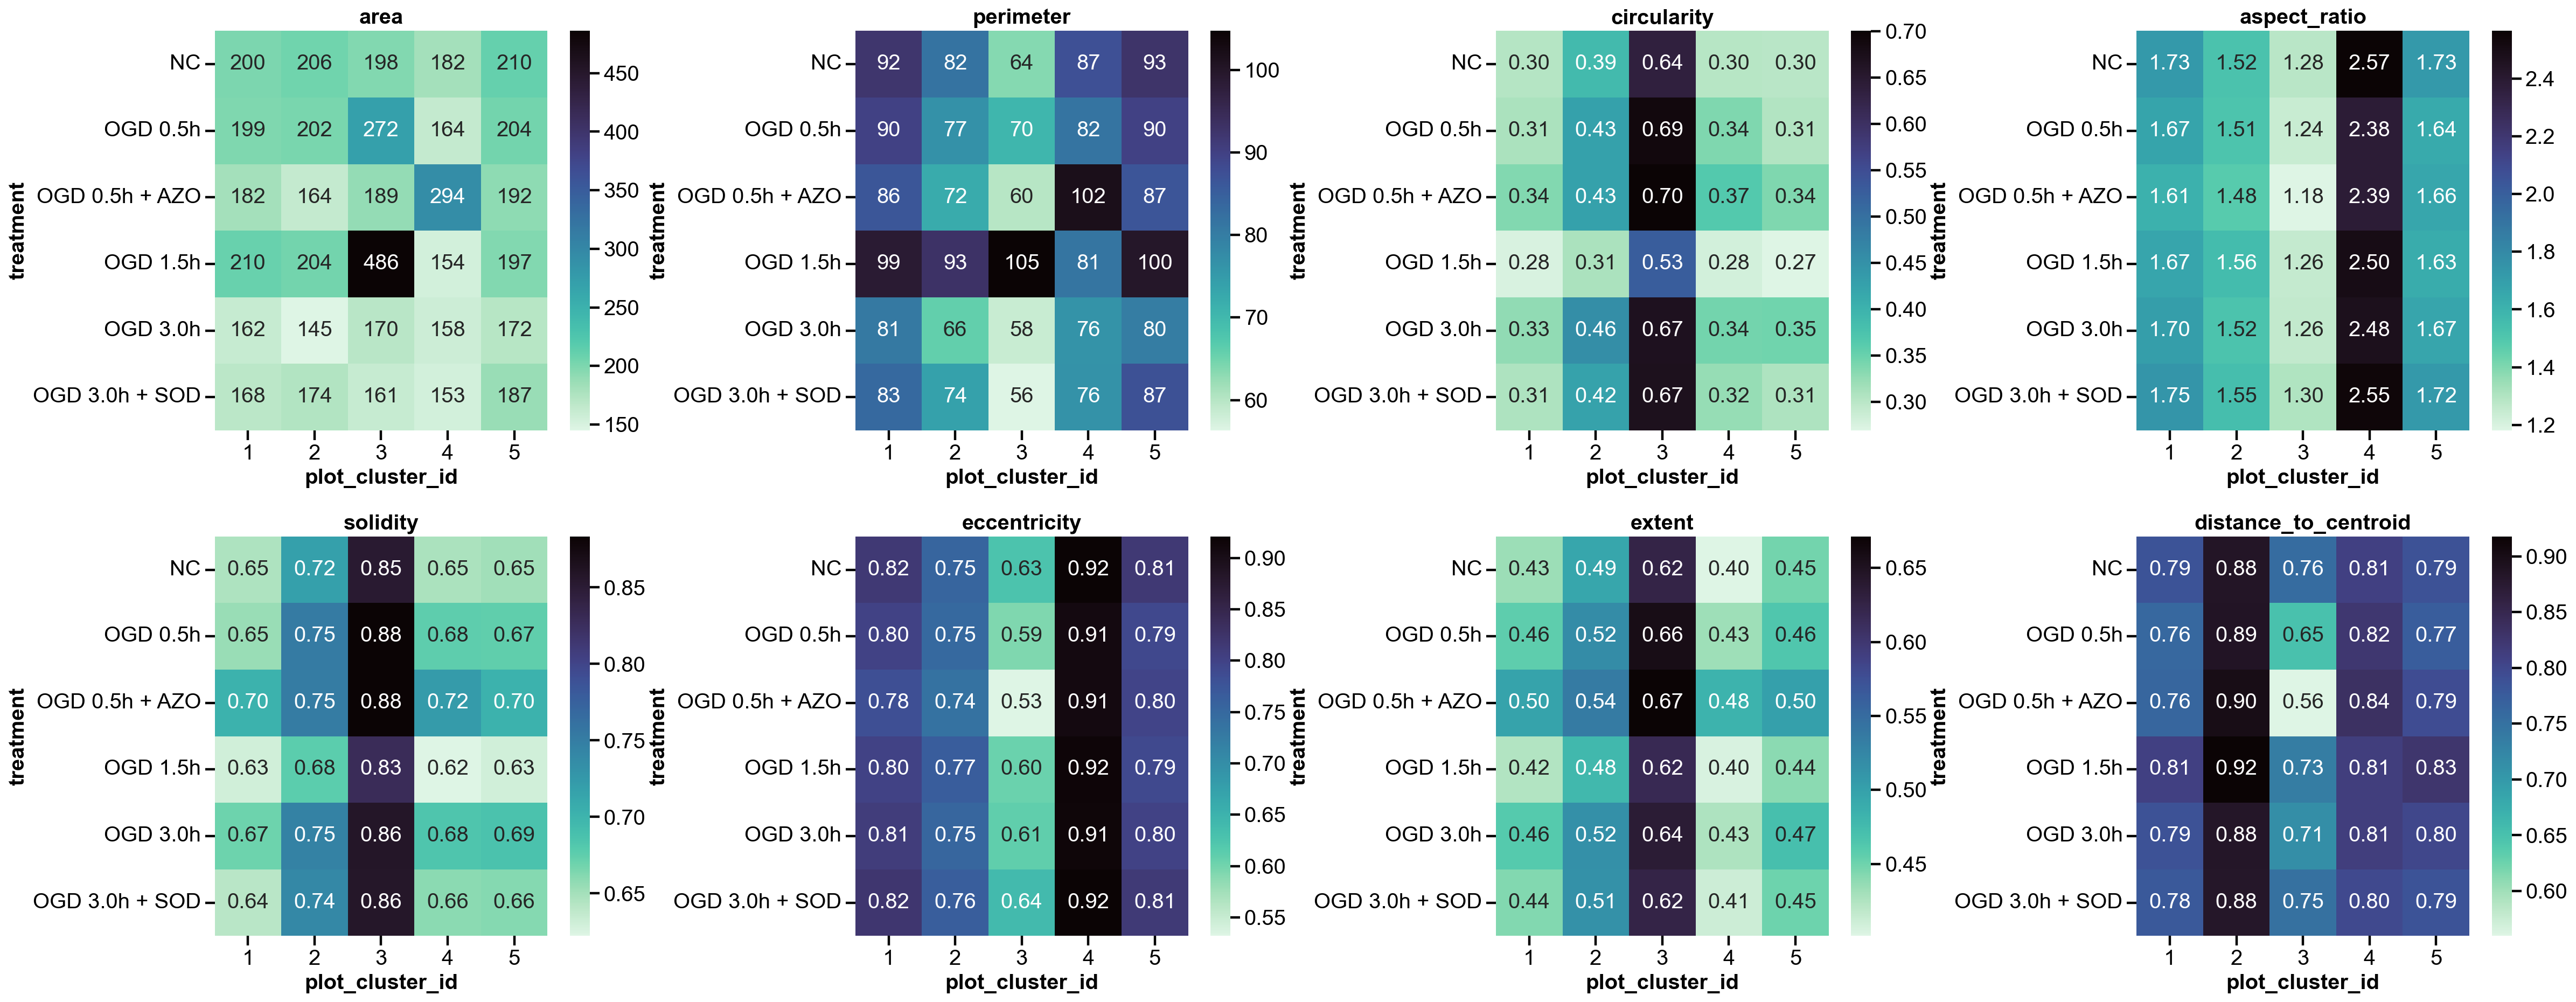

In [28]:
col = 4
row = 2
scale = 6

fig, axs = plt.subplots(row, col, figsize=((col+1)*scale, row*scale))
for row_i in range(row):
    for col_i in range(col):
        i = row_i*col + col_i
        if i < len(properties):
            heatmap_df = get_heatmap_df(otsu_properties_df, properties[i], 'treatment', 'plot_cluster_id')
            if heatmap_df.max().max() > 10:
                fmt = '.0f'
            else:
                fmt = '.2f'
                
            sns.heatmap(
                heatmap_df,
                square=True,
                annot=True,
                fmt=fmt,
                ax=axs[row_i, col_i],
                cmap='mako_r'
            )
            axs[row_i, col_i].set_title(properties[i])
plt.tight_layout()

#### Region vs. cluster

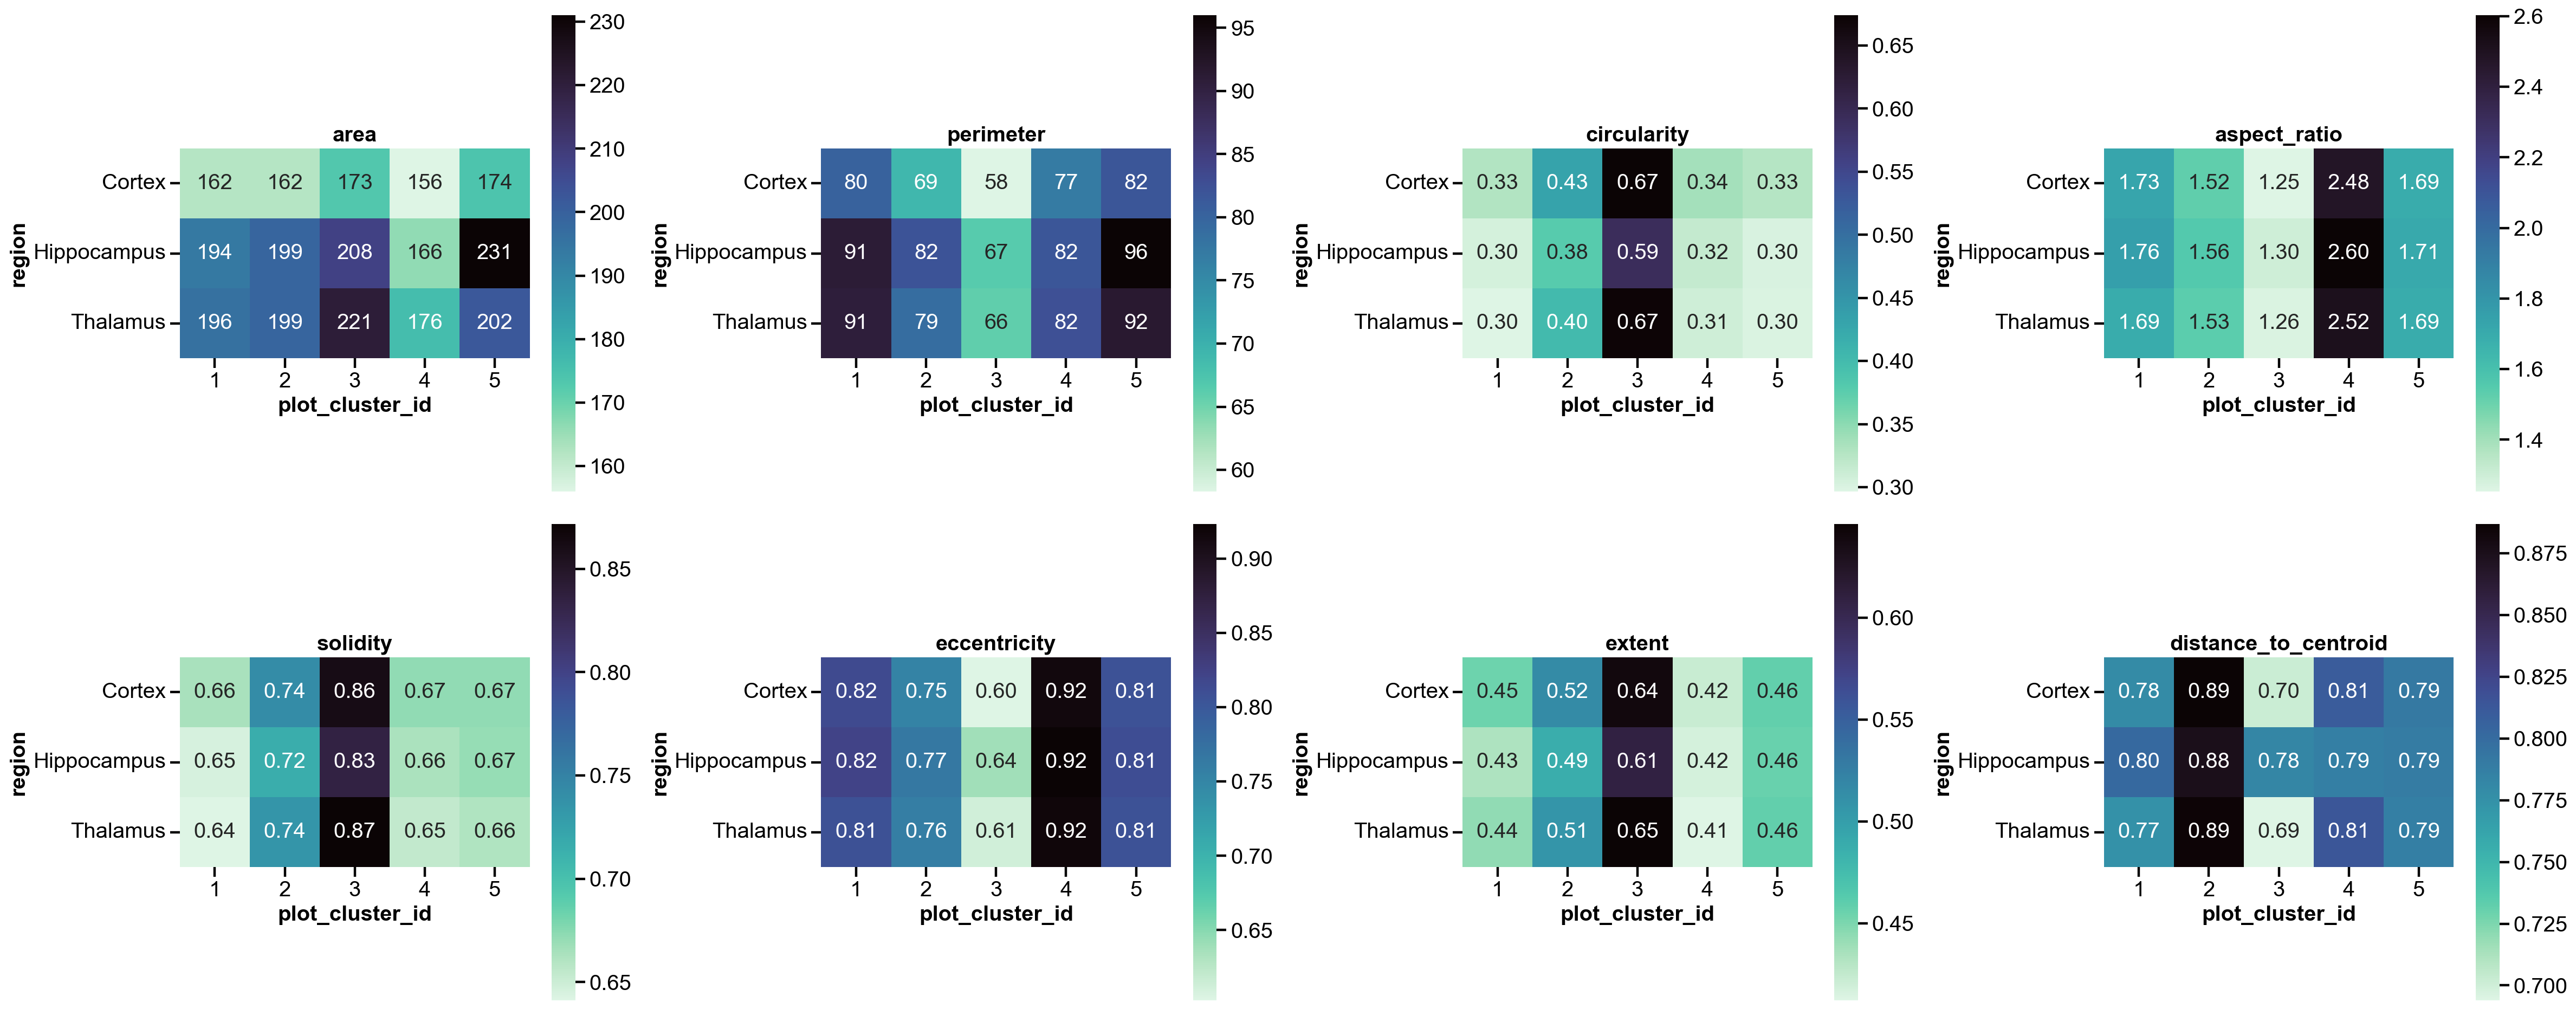

In [29]:
col = 4
row = 2
scale = 6

fig, axs = plt.subplots(row, col, figsize=((col+1)*scale, row*scale))
for row_i in range(row):
    for col_i in range(col):
        i = row_i*col + col_i
        if i < len(properties):
            heatmap_df = get_heatmap_df(otsu_properties_df, properties[i], 'region', 'plot_cluster_id')
            if heatmap_df.max().max() > 10:
                fmt = '.0f'
            else:
                fmt = '.2f'
                
            sns.heatmap(
                heatmap_df,
                square=True,
                annot=True,
                fmt=fmt,
                ax=axs[row_i, col_i],
                cmap='mako_r'
            )
            axs[row_i, col_i].set_title(properties[i])
plt.tight_layout()

#### Treatment vs. region

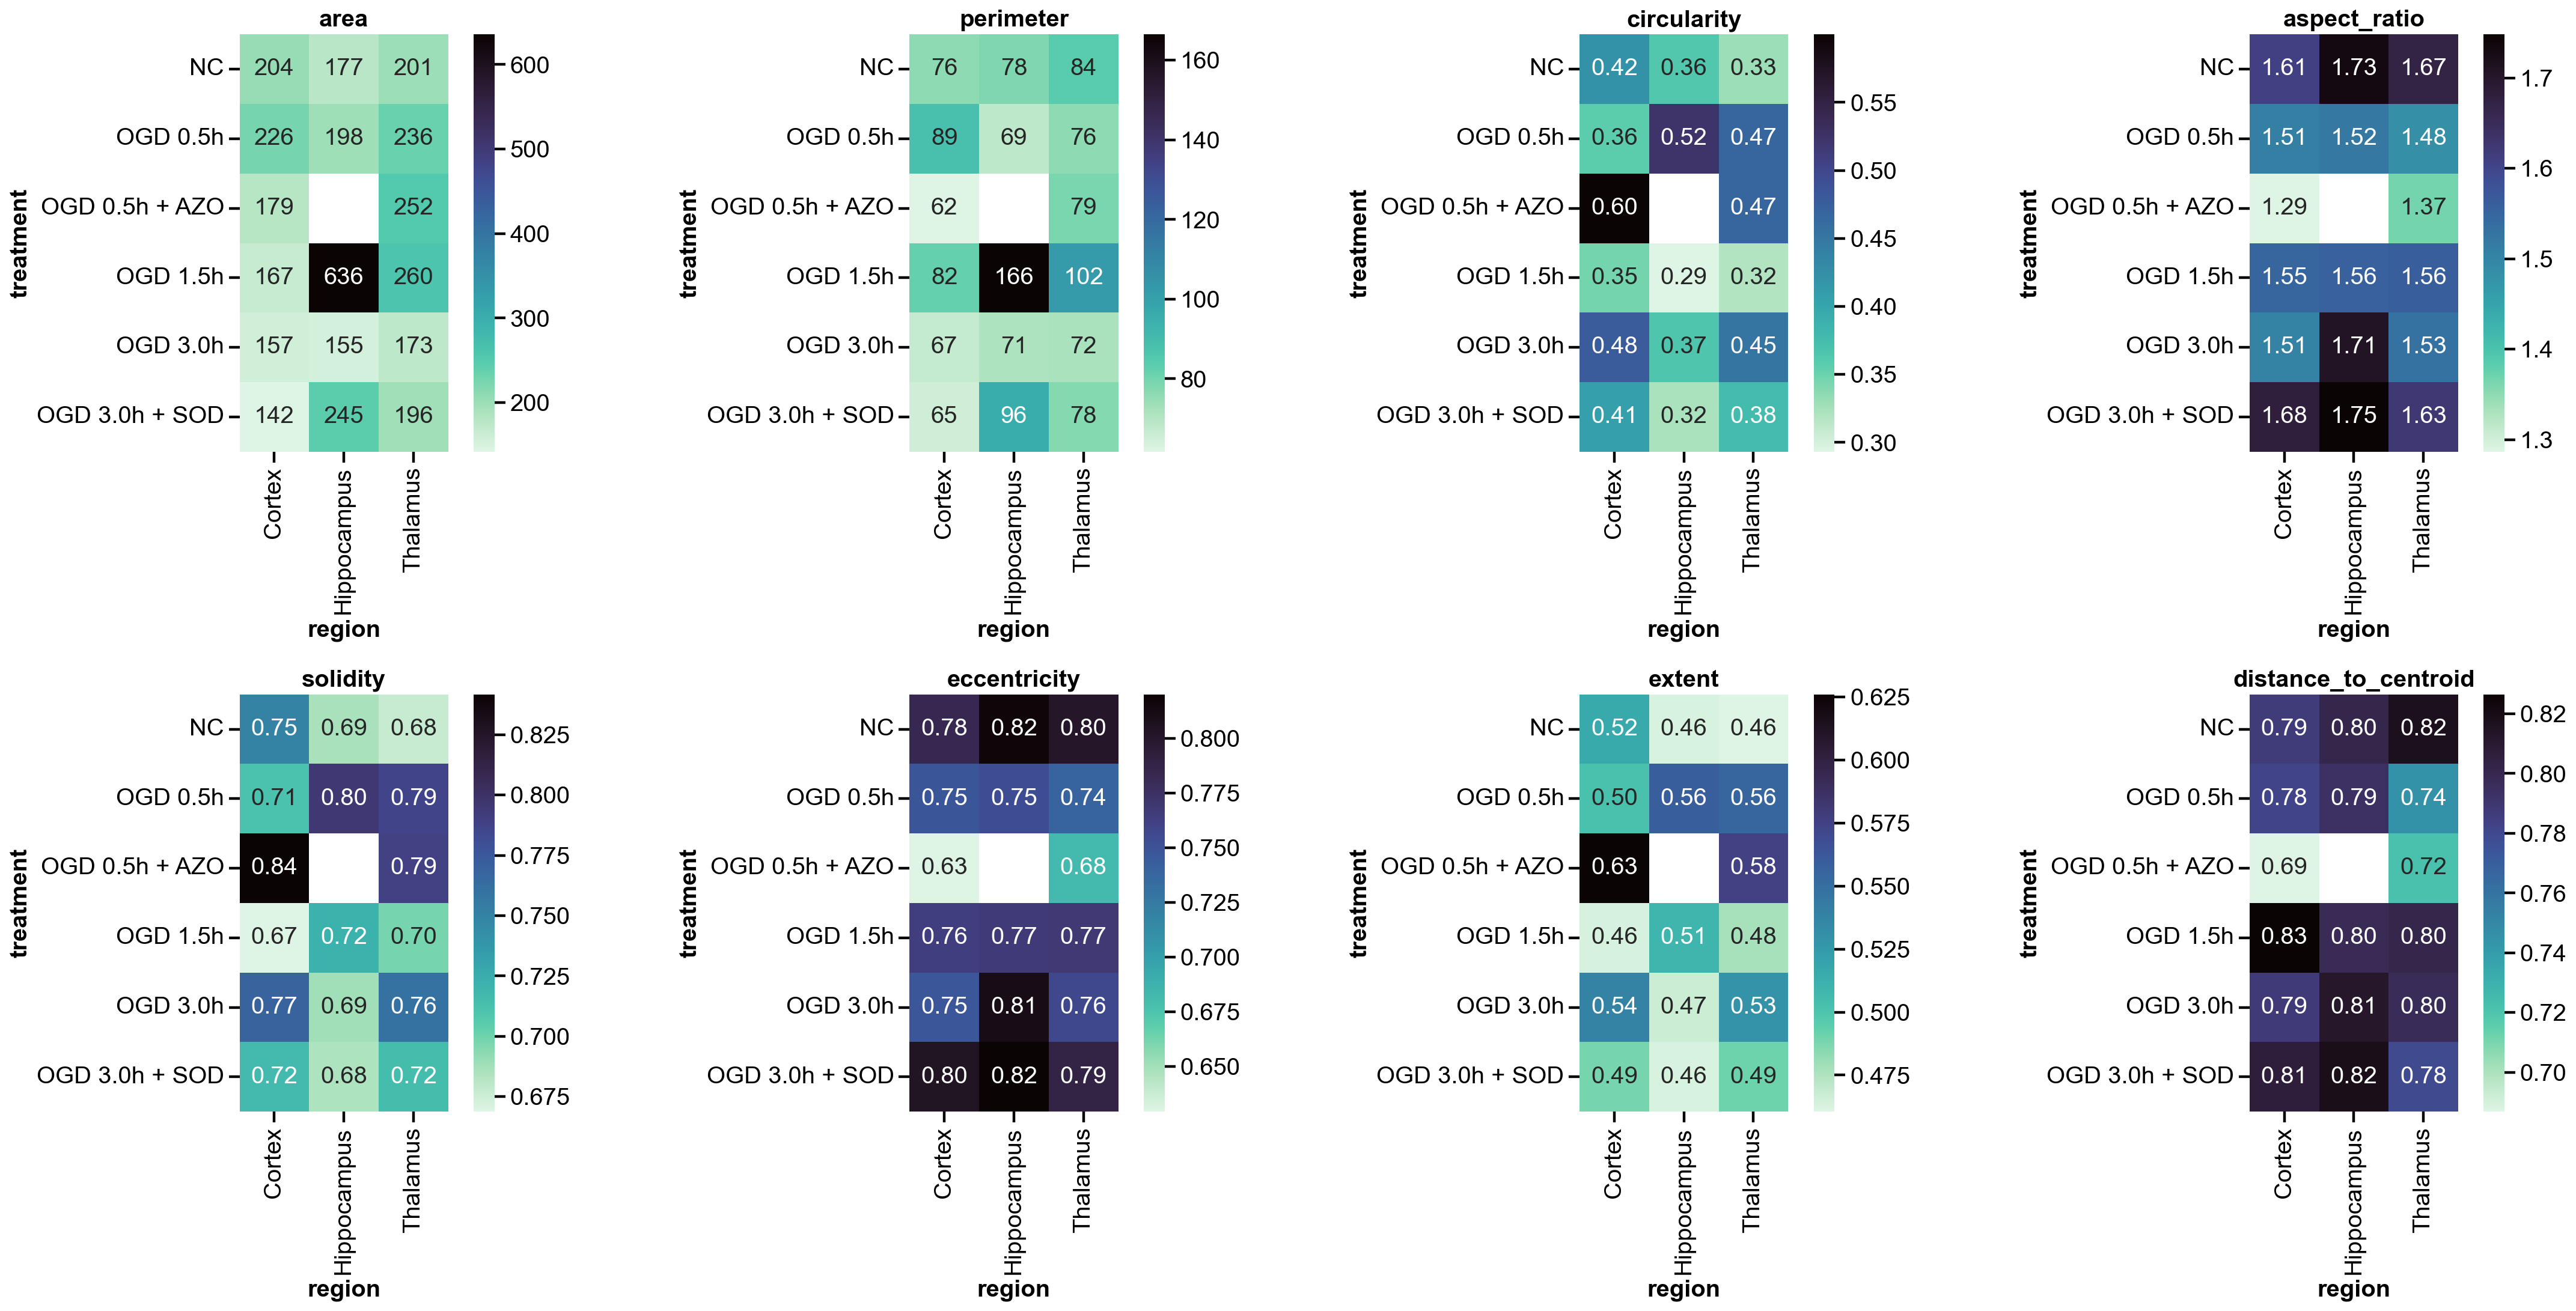

In [30]:
col = 4
row = 2
scale = 7

fig, axs = plt.subplots(row, col, figsize=(col*scale, row*scale))
for row_i in range(row):
    for col_i in range(col):
        i = row_i*col + col_i
        if i < len(properties):
            heatmap_df = get_heatmap_df(otsu_properties_df, properties[i], 'treatment', 'region')
            if heatmap_df.max().max() > 10:
                fmt = '.0f'
            else:
                fmt = '.2f'
                
            sns.heatmap(
                heatmap_df,
                square=True,
                annot=True,
                fmt=fmt,
                ax=axs[row_i, col_i],
                cmap='mako_r'
            )
            axs[row_i, col_i].set_title(properties[i])
plt.tight_layout()

### Changes of morphological parameters

#### Functions for plotting changes

In [31]:
def compute_arrow(df, feature, category, category_item,
                  controlled_category, init_controlled_category, final_controlled_category):
    """
    Calculate the initial y value of arrow and the length of the arrow.
    
    Parameters
    ----------
    df : DataFrame
        Contains `feature`, `category`, and `controlled_category` columns.
    feature : str
        Name of numerical column to be used on y-axis.
    category : str
        Name of categorical column to be used on x-axis.
    category_item : str
        Name of category item for arrow comparison. 
    controlled_category : str
        Name of controlled categorical column to be used for subplots.
    init_controlled_category : str
        Name of controlled category set as baseline.
    final_controlled_category : str
        Name of controlled category to be compared to baseline.
        
    Returns
    -------
    init_value : float
        y value of the arrow's initial value.
    difference : float
        Difference in y value (length) of the arrow.
    """
    cluster_cond = df[category] == category_item
    treatment_cond = df[controlled_category] == init_controlled_category
    init_value = df[cluster_cond & treatment_cond][feature].values[0]
    cluster_cond = df[category] == category_item
    treatment_cond = df[controlled_category] == final_controlled_category
    final_value = df[cluster_cond & treatment_cond][feature].values[0]
    difference = final_value - init_value
    return init_value, difference

In [32]:
def plot_arrow(df, feature, category, controlled_category, init_controlled_category, final_controlled_category, ax, displace=1, facecolor='black'):
    """
    Plot an arrow from initial value to final value for all categories in x-axis.
    
    Parameters
    ----------
    df : DataFrame
        Contains `feature`, `category`, and `controlled_category` columns.
    feature : str
        Name of numerical column to be used on y-axis.
    category : str
        Name of categorical column to be used on x-axis.
    controlled_category : str
        Name of controlled categorical column to be used for subplots.
    init_controlled_category : str
        Name of controlled category set as baseline.
    final_controlled_category : str
        Name of controlled category to be compared to baseline.
    ax : matplotlib.axes.Axes
    displace : int
        Horizontal displacement of arrow from the original plot. Default 1.
    facecolor : str
        Facecolor of arrow.
    """
    category_items = np.unique(df[category])
    head_langth = 0.03 * np.diff(ax.get_ylim())[0]  # scale the arrow head length
    for i, category_item in enumerate(category_items):
        init, diff = compute_arrow(
            df=df,
            feature=feature, 
            category=category, 
            category_item=category_item,
            controlled_category=controlled_category, 
            init_controlled_category=init_controlled_category, 
            final_controlled_category=final_controlled_category
        )
        if abs(diff) >= head_langth:  # does not show small changes
            ax.arrow(
                i+0.15*displace, 
                init,
                0, 
                diff, 
                length_includes_head=True, 
                width=0.03, 
                head_width=0.1, 
                head_length=head_langth,
                facecolor=facecolor, 
                edgecolor='none'
            )

In [33]:
def plot_baseline_arrows(df, feature, category, controlled_category, init_controlled_category, ax, cmap=plt.get_cmap("tab10")):
    """
    Plot arrows from a baseline initial value to final values of different 
    controlled categories for all categories in x-axis.
    
    Parameters
    ----------
    df : DataFrame
        Contains `feature`, `category`, and `controlled_category` columns.
    feature : str
        Name of numerical column to be used on y-axis.
    category : str
        Name of categorical column to be used on x-axis.
    controlled_category : str
        Name of controlled categorical column to be used for subplots.
    init_controlled_category : str
        Name of controlled category set as baseline.
    ax : matplotlib.axes.Axes
    cmap : plt.get_cmap()
    """
    controlled_category_items = np.unique(df[controlled_category])
    for j, controlled_category_item in enumerate(controlled_category_items):
        plot_arrow(
            df=df, 
            feature=feature, 
            category=category, 
            controlled_category=controlled_category, 
            init_controlled_category=init_controlled_category, 
            final_controlled_category=controlled_category_item, 
            ax=ax, 
            displace=j+1, 
            facecolor=cmap(j)
        )

In [34]:
def plot_basline_change(df, feature, category, controlled_category, init_controlled_category, ax, cmap=plt.get_cmap("tab10")):
    """
    Plots changes of numerical feature in response to one categorical variable
    while holding another categorical variable constant for all categories
    compared to a baseline.
    
    Parameters
    ----------
    df : DataFrame
        Contains `feature`, `category`, and `controlled_category` columns.
    feature : str
        Name of numerical column to be used on y-axis.
    category : str
        Name of categorical column to be used on x-axis.
    controlled_category : str
        Name of controlled categorical column to be used for subplots.
    init_controlled_category : str
        Name of controlled category set as baseline.
    ax : matplotlib.axes.Axes
    cmap : plt.get_cmap()
    """
    sns.stripplot(
        x=category, 
        y=feature, 
        hue=controlled_category,  
        data=df, 
        jitter=False, 
        marker='o', 
        ax=ax
    )
    plot_baseline_arrows(
        df=df, 
        feature=feature, 
        category=category, 
        controlled_category=controlled_category, 
        init_controlled_category=init_controlled_category, 
        ax=ax, 
        cmap=cmap
    )
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [172]:
def plot_change(df, feature, category, controlled_category, init_controlled_categories, final_controlled_categories, facecolors, ax):
    """
    Plots changes of numerical feature in response to one categorical variable
    while holding another categorical variable constant for
    `init_controlled_categories` compared to `final_controlled_categories`.
    
    Parameters
    ----------
    df : DataFrame
        Contains `feature`, `category`, and `controlled_category` columns.
    feature : str
        Name of numerical column to be used on y-axis.
    category : str
        Name of categorical column to be used on x-axis.
    controlled_category : str
        Name of controlled categorical column to be used for subplots.
    init_controlled_categories : list
        Names of controlled category set as baseline.
    final_controlled_categories : list
        Names of controlled category compared to baseline.
    point_colors : list
        Names of colors of points.
    facecolors : list
        Names of facecolors of arrows.
    ax : matplotlib.axes.Axes
    
    Raises
    ------
    ValueError
        If `init_controlled_categories`, `final_controlled_categories`, 
        and `facecolors` does not have the same length.
    """
    if not len(init_controlled_categories) == len(final_controlled_categories) == len(facecolors):
        raise ValueError('`init_controlled_categories`, `final_controlled_categories`, and `facecolors` does not have the same length.')
    sns.stripplot(
        x=category, 
        y=feature, 
        hue=controlled_category,  
        data=df, 
        jitter=False, 
        marker='o', 
        ax=ax,
    )
    for i in range(len(init_controlled_categories)):
        plot_arrow(
            df=df, 
            feature=feature, 
            category=category, 
            controlled_category=controlled_category, 
            init_controlled_category=init_controlled_categories[i], 
            final_controlled_category=final_controlled_categories[i],
            displace=i+1,
            ax=ax, 
            facecolor=facecolors[i]
        )
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#### Variation in regions

In [36]:
region_df = otsu_properties_df.groupby(by=['region', 'plot_cluster_id']).agg('median').reset_index()
region_df.head()

region  plot_cluster_id  image_id  label  centroid-y  centroid-x   area  \
0  Cortex                1     311.0   49.0  315.917776  334.193789  162.0   
1  Cortex                2     296.0   46.0  321.558824  324.096866  162.0   
2  Cortex                3     354.0   46.0  284.036530  294.260417  173.0   
3  Cortex                4     278.0   51.0  324.054167  350.597087  156.0   
4  Cortex                5     319.0   47.0  299.070946  319.926433  174.0   

   bbox_area  convex_area  filled_area  ...  minor_axis_length  orientation  \
0      374.0        256.0        162.0  ...          13.524199    -0.055766   
1      330.0        220.0        162.0  ...          13.099976     0.040983   
2      272.0        205.0        173.0  ...          13.756224    -0.037797   
3      378.0        239.0        156.0  ...          10.454945     0.002023   
4      392.0        269.0        174.0  ...          13.647540    -0.037910   

   euler_number  eccentricity  solidity    extent  circularity  aspect_ratio  \
0           1.0      0.815172  0.663986  0.454703     0.328253      1.726462   
1           1.0      0.754110  0.742821  0.515625     0.431564      1.522654   
2           1.0      0.602748  0.861386  0.640097     0.673952      1.253240   
3           1.0      0.915161  0.671875  0.422857     0.337213      2.480851   
4           1.0      0.806411  0.672131  0.458333     0.327400      1.691029   

   cluster_id  distance_to_centroid  
0         0.0              0.779444  
1         1.0              0.886852  
2         2.0              0.702221  
3         3.0              0.810706  
4         4.0              0.791635  

[5 rows x 23 columns]

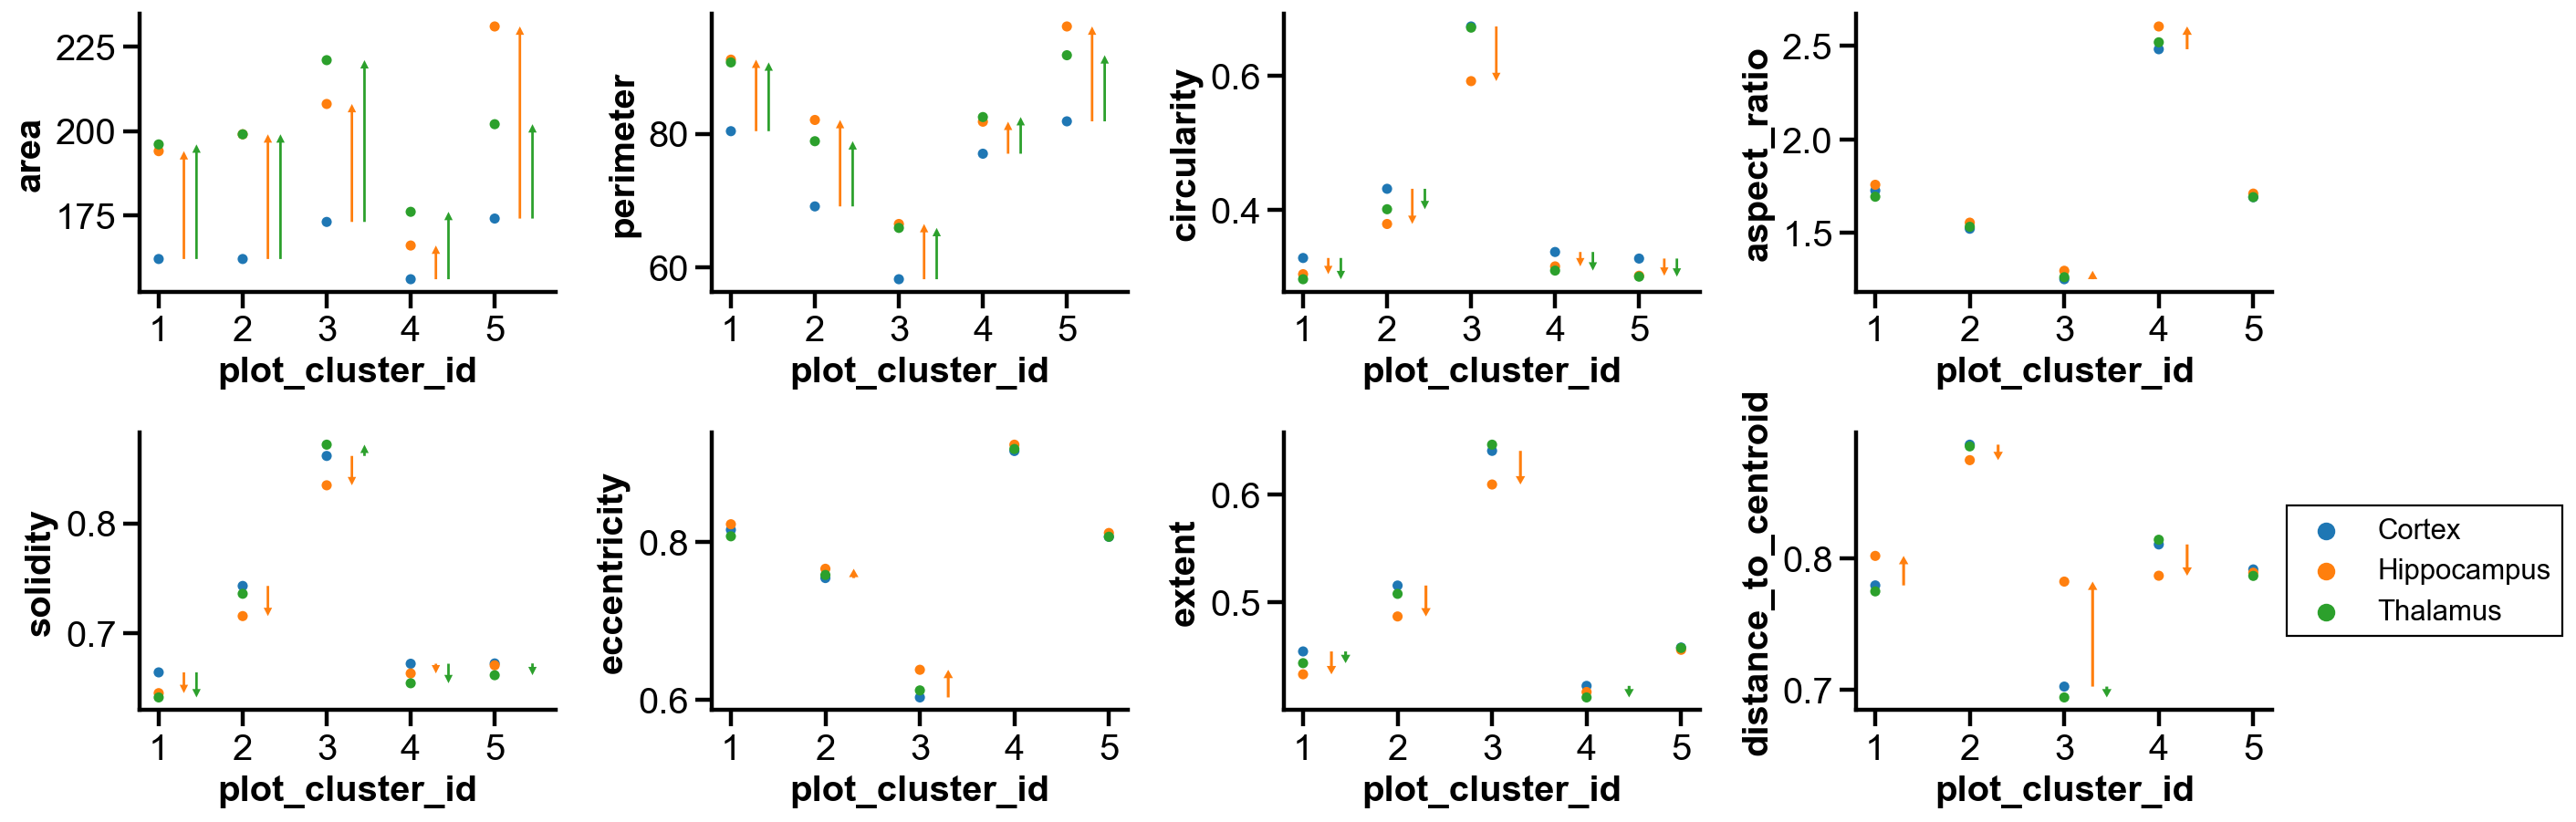

In [37]:
col = 4
row = 2
scale = 6

fig, axs = plt.subplots(row, col, figsize=((col-1)*scale, (row-1)*scale))
for row_i in range(row):
    for col_i in range(col):
        i = row_i*col + col_i
        if i < len(properties):
            plot_basline_change(
                df=region_df, 
                feature=properties[i], 
                category='plot_cluster_id', 
                controlled_category='region', 
                init_controlled_category='Cortex', 
                ax=axs[row_i, col_i]
            )
            axs[row_i, col_i].legend().set_visible(False)
axs[-1, -1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

#### Changes in response to injury

In [38]:
injury_df = otsu_properties_df.groupby(by=['treatment', 'plot_cluster_id']).agg('median').reset_index()
injury_cond = (~injury_df['treatment'].isin(['OGD 0.5h + AZO', 'OGD 3.0h + SOD']))
injury_df = injury_df[injury_cond]
injury_df.head()

treatment  plot_cluster_id  image_id  label  centroid-y  centroid-x   area  \
0        NC                1     470.0   51.0  266.344444  262.966495  200.0   
1        NC                2     431.0   52.0  263.574392  247.786517  206.0   
2        NC                3     431.0   52.0  250.717279  254.162879  198.0   
3        NC                4     431.0   49.0  267.444611  254.068104  182.0   
4        NC                5     470.0   50.0  257.336373  262.475411  210.5   

   bbox_area  convex_area  filled_area  ...  minor_axis_length  orientation  \
0      462.0        312.0        200.0  ...          15.204559    -0.043801   
1      418.0        294.0        206.0  ...          15.130211    -0.063086   
2      323.0        238.0        198.0  ...          14.522494    -0.107833   
3      460.0        287.5        182.0  ...          11.357266    -0.021286   
4      461.0        318.0        210.5  ...          15.082752    -0.112400   

   euler_number  eccentricity  solidity    extent  circularity  aspect_ratio  \
0           1.0      0.815085  0.645933  0.433566     0.303864      1.726096   
1           1.0      0.753928  0.718821  0.494709     0.388129      1.522170   
2           1.0      0.626628  0.851946  0.625000     0.636031      1.283173   
3           1.0      0.920876  0.647539  0.401369     0.302431      2.565048   
4           1.0      0.814912  0.651584  0.448117     0.300615      1.725373   

   cluster_id  distance_to_centroid  
0         0.0              0.785398  
1         1.0              0.884309  
2         2.0              0.756539  
3         3.0              0.809818  
4         4.0              0.787132  

[5 rows x 23 columns]

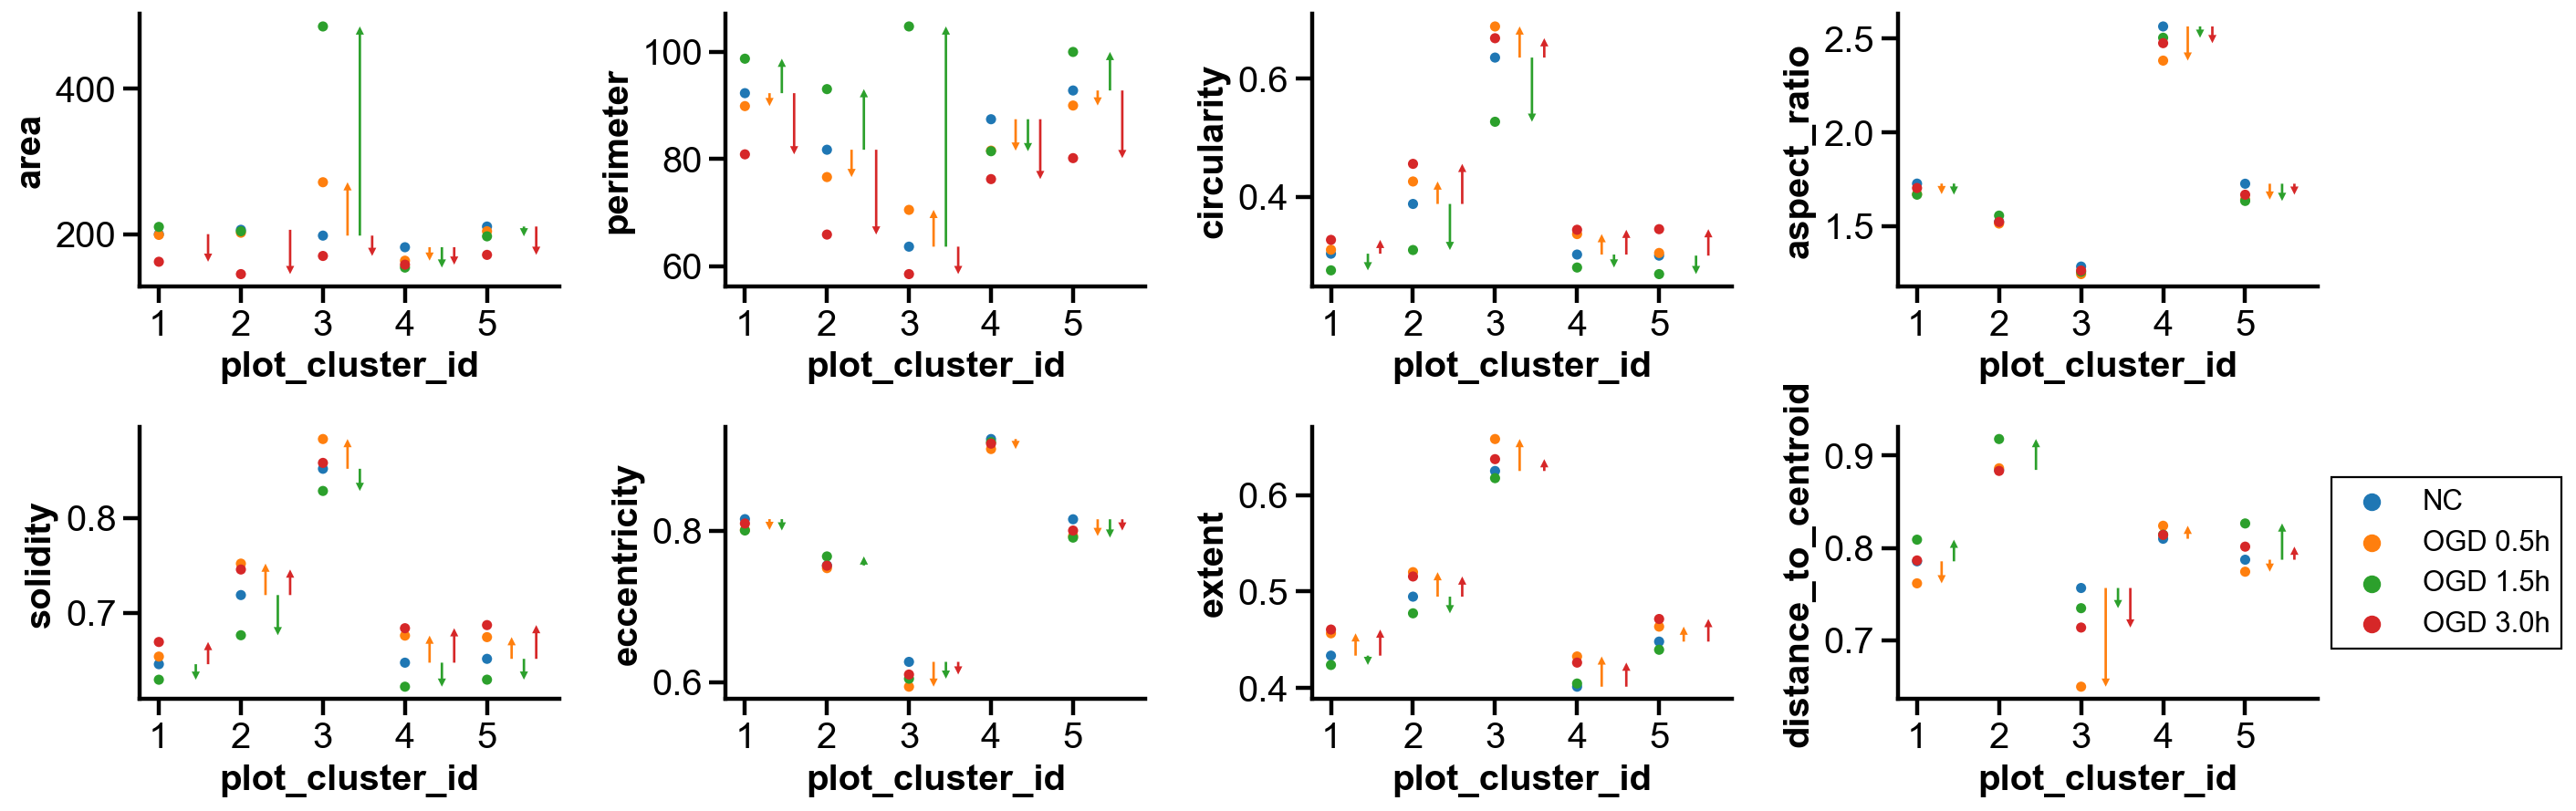

In [39]:
col = 4
row = 2
scale = 6

fig, axs = plt.subplots(row, col, figsize=((col-1)*scale, (row-1)*scale))
for row_i in range(row):
    for col_i in range(col):
        i = row_i*col + col_i
        if i < len(properties):
            plot_basline_change(
                df=injury_df, 
                feature=properties[i], 
                category='plot_cluster_id', 
                controlled_category='treatment', 
                init_controlled_category='NC', 
                ax=axs[row_i, col_i]
            )
            axs[row_i, col_i].legend().set_visible(False)
axs[-1, -1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

#### Changes of OGD 0.5h in response to AZO treatemnt

In [40]:
azo_treatment_df = otsu_properties_df.groupby(by=['treatment', 'plot_cluster_id']).agg('median').reset_index()
azo_treatment_cond = (azo_treatment_df['treatment'].isin(['NC', 'OGD 0.5h', 'OGD 0.5h + AZO']))
azo_treatment_df = azo_treatment_df[azo_treatment_cond]
azo_treatment_df.head()

treatment  plot_cluster_id  image_id  label  centroid-y  centroid-x   area  \
0        NC                1     470.0   51.0  266.344444  262.966495  200.0   
1        NC                2     431.0   52.0  263.574392  247.786517  206.0   
2        NC                3     431.0   52.0  250.717279  254.162879  198.0   
3        NC                4     431.0   49.0  267.444611  254.068104  182.0   
4        NC                5     470.0   50.0  257.336373  262.475411  210.5   

   bbox_area  convex_area  filled_area  ...  minor_axis_length  orientation  \
0      462.0        312.0        200.0  ...          15.204559    -0.043801   
1      418.0        294.0        206.0  ...          15.130211    -0.063086   
2      323.0        238.0        198.0  ...          14.522494    -0.107833   
3      460.0        287.5        182.0  ...          11.357266    -0.021286   
4      461.0        318.0        210.5  ...          15.082752    -0.112400   

   euler_number  eccentricity  solidity    extent  circularity  aspect_ratio  \
0           1.0      0.815085  0.645933  0.433566     0.303864      1.726096   
1           1.0      0.753928  0.718821  0.494709     0.388129      1.522170   
2           1.0      0.626628  0.851946  0.625000     0.636031      1.283173   
3           1.0      0.920876  0.647539  0.401369     0.302431      2.565048   
4           1.0      0.814912  0.651584  0.448117     0.300615      1.725373   

   cluster_id  distance_to_centroid  
0         0.0              0.785398  
1         1.0              0.884309  
2         2.0              0.756539  
3         3.0              0.809818  
4         4.0              0.787132  

[5 rows x 23 columns]

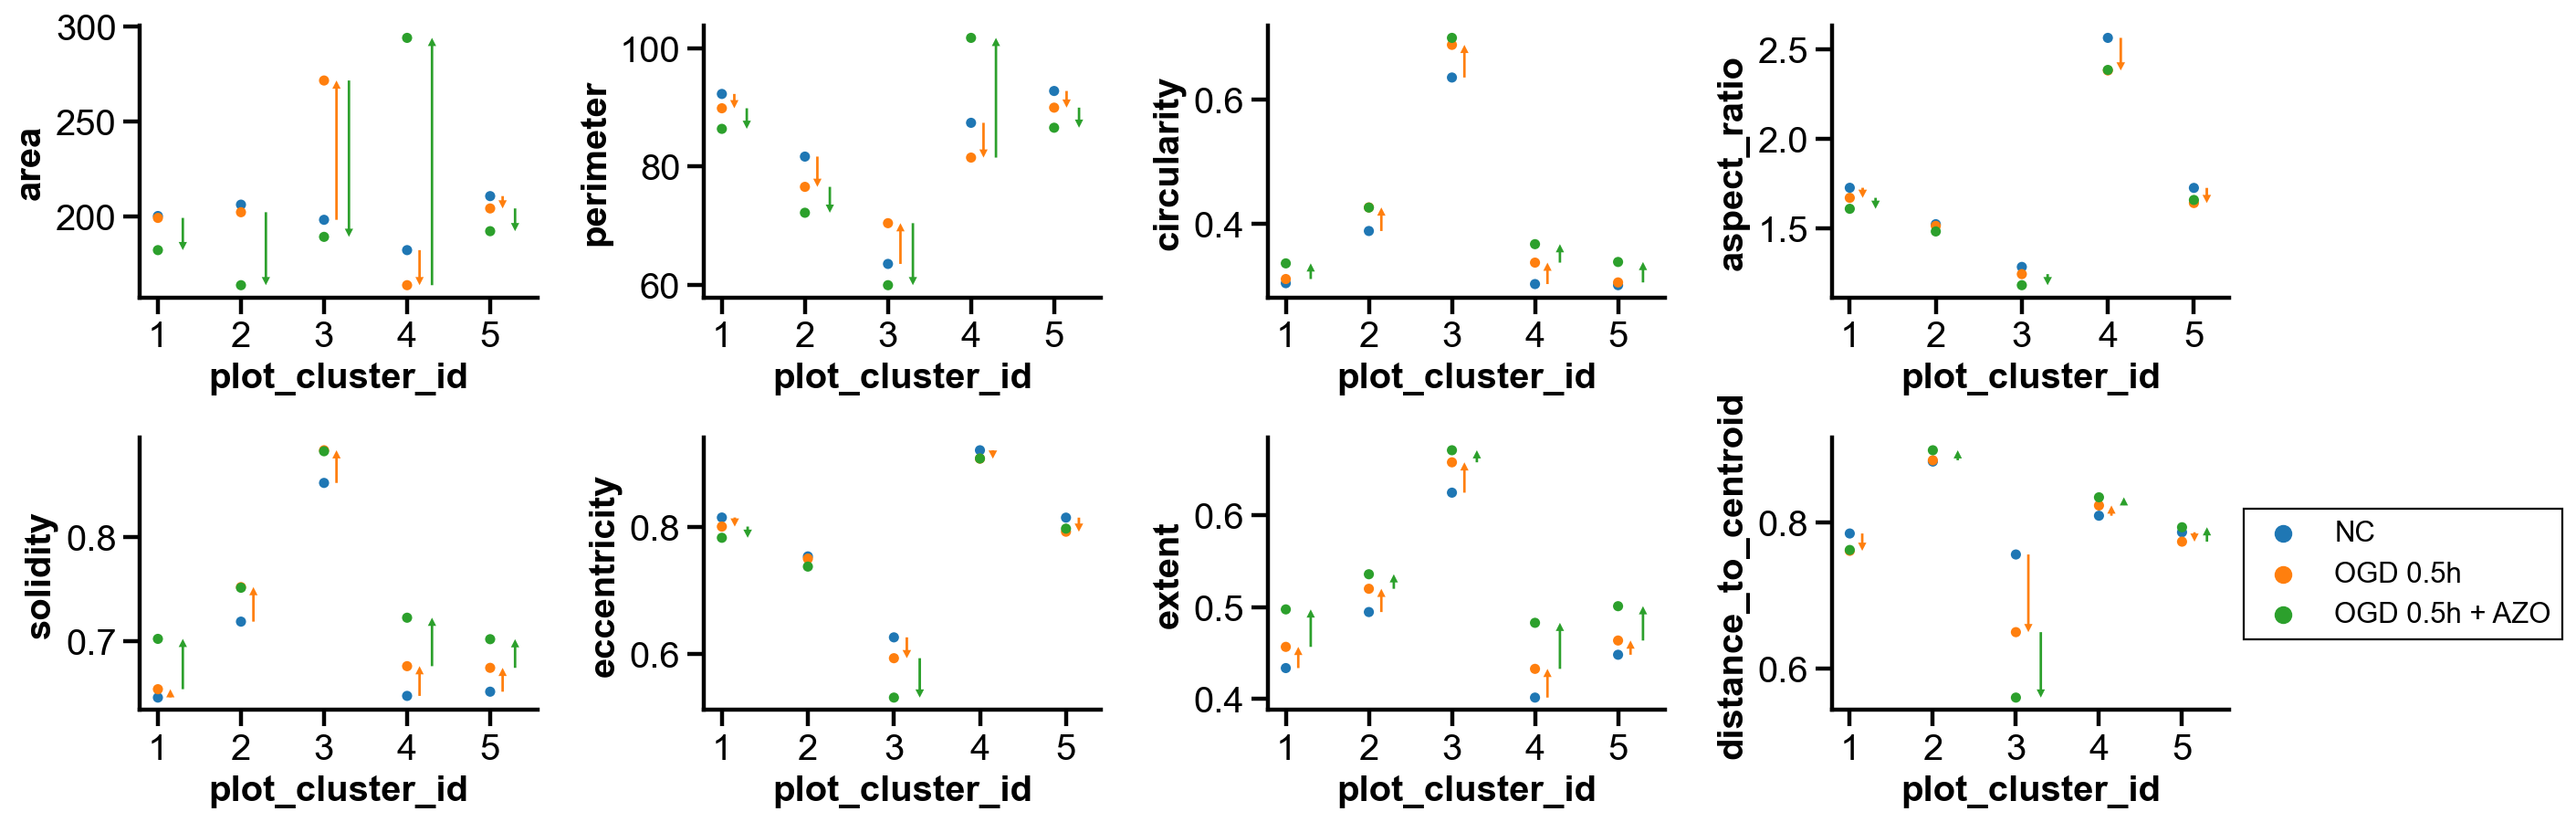

In [41]:
col = 4
row = 2
scale = 6

fig, axs = plt.subplots(row, col, figsize=((col-1)*scale, (row-1)*scale))
for row_i in range(row):
    for col_i in range(col):
        i = row_i*col + col_i
        if i < len(properties):
            plot_change(
                df=azo_treatment_df, 
                feature=properties[i], 
                category='plot_cluster_id', 
                controlled_category='treatment', 
                init_controlled_categories=['NC', 'OGD 0.5h'], 
                final_controlled_categories=['OGD 0.5h', 'OGD 0.5h + AZO'], 
                facecolors=['tab:orange', 'tab:green'],
                ax=axs[row_i, col_i]
            )
            axs[row_i, col_i].legend().set_visible(False)
axs[-1, -1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

#### Changes of OGD 3.0h in response to SOD treatemnt

In [42]:
sod_treatment_df = otsu_properties_df.groupby(by=['treatment', 'plot_cluster_id']).agg('median').reset_index()
sod_treatment_cond = (sod_treatment_df['treatment'].isin(['NC', 'OGD 3.0h', 'OGD 3.0h + SOD']))
sod_treatment_df = sod_treatment_df[sod_treatment_cond]
sod_treatment_df.head()

treatment  plot_cluster_id  image_id  label  centroid-y  centroid-x   area  \
0        NC                1     470.0   51.0  266.344444  262.966495  200.0   
1        NC                2     431.0   52.0  263.574392  247.786517  206.0   
2        NC                3     431.0   52.0  250.717279  254.162879  198.0   
3        NC                4     431.0   49.0  267.444611  254.068104  182.0   
4        NC                5     470.0   50.0  257.336373  262.475411  210.5   

   bbox_area  convex_area  filled_area  ...  minor_axis_length  orientation  \
0      462.0        312.0        200.0  ...          15.204559    -0.043801   
1      418.0        294.0        206.0  ...          15.130211    -0.063086   
2      323.0        238.0        198.0  ...          14.522494    -0.107833   
3      460.0        287.5        182.0  ...          11.357266    -0.021286   
4      461.0        318.0        210.5  ...          15.082752    -0.112400   

   euler_number  eccentricity  solidity    extent  circularity  aspect_ratio  \
0           1.0      0.815085  0.645933  0.433566     0.303864      1.726096   
1           1.0      0.753928  0.718821  0.494709     0.388129      1.522170   
2           1.0      0.626628  0.851946  0.625000     0.636031      1.283173   
3           1.0      0.920876  0.647539  0.401369     0.302431      2.565048   
4           1.0      0.814912  0.651584  0.448117     0.300615      1.725373   

   cluster_id  distance_to_centroid  
0         0.0              0.785398  
1         1.0              0.884309  
2         2.0              0.756539  
3         3.0              0.809818  
4         4.0              0.787132  

[5 rows x 23 columns]

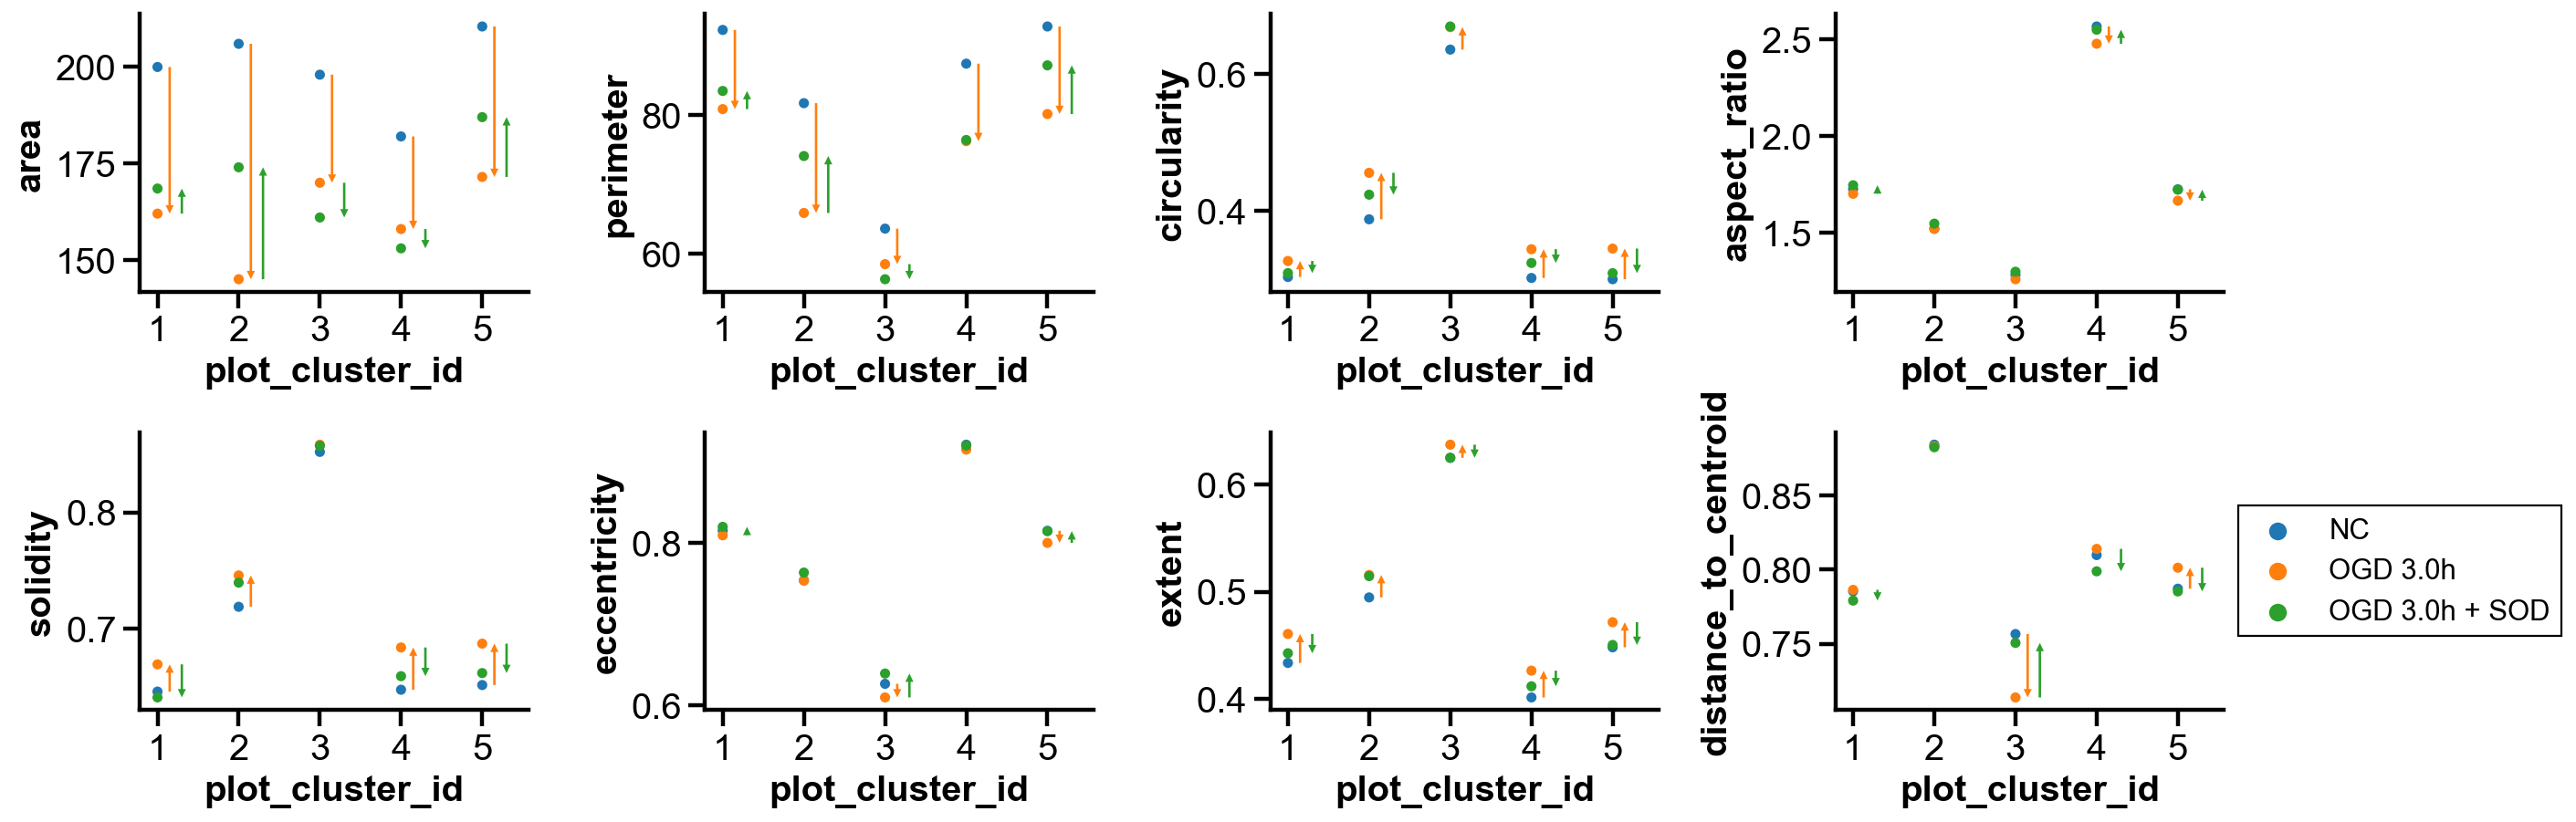

In [43]:
col = 4
row = 2
scale = 6

fig, axs = plt.subplots(row, col, figsize=((col-1)*scale, (row-1)*scale))
for row_i in range(row):
    for col_i in range(col):
        i = row_i*col + col_i
        if i < len(properties):
            plot_change(
                df=sod_treatment_df, 
                feature=properties[i], 
                category='plot_cluster_id', 
                controlled_category='treatment', 
                init_controlled_categories=['NC', 'OGD 3.0h'], 
                final_controlled_categories=['OGD 3.0h', 'OGD 3.0h + SOD'], 
                facecolors=['tab:orange', 'tab:green'],
                ax=axs[row_i, col_i]
            )
            axs[row_i, col_i].legend().set_visible(False)
axs[-1, -1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

### Heatmap for heterogeneity

In [44]:
otsu_properties_df.groupby(by=['region', 'treatment', 'plot_cluster_id']).agg('median')

image_id  label  centroid-y  \
region   treatment      plot_cluster_id                                
Cortex   NC             1                   470.0   46.5  264.867039   
                        2                   470.0   42.0  237.137615   
                        3                   493.0   46.0  232.976054   
                        4                   470.0   39.0  222.176966   
                        5                   470.0   48.0  252.582915   
...                                           ...    ...         ...   
Thalamus OGD 3.0h + SOD 1                   468.0   55.0  275.380282   
                        2                   458.0   54.0  272.702149   
                        3                   468.0   55.0  248.152750   
                        4                   468.0   46.0  252.574262   
                        5                   458.0   47.0  238.552239   

                                         centroid-x   area  bbox_area  \
region   treatment      plot_cluster_id                                 
Cortex   NC             1                261.336136  194.0      426.0   
                        2                204.056818  216.0      420.0   
                        3                252.277393  211.5      340.0   
                        4                232.615000  203.0      484.0   
                        5                269.988764  202.0      440.0   
...                                             ...    ...        ...   
Thalamus OGD 3.0h + SOD 1                256.562963  183.0      460.0   
                        2                267.882914  220.0      437.0   
                        3                264.084516  199.5      306.0   
                        4                278.604470  165.5      420.0   
                        5                262.170455  204.0      483.0   

                                         convex_area  filled_area  perimeter  \
region   treatment      plot_cluster_id                                        
Cortex   NC             1                      299.5        194.0  89.165999   
                        2                      285.0        216.0  77.805087   
                        3                      251.0        211.5  63.870058   
                        4                      307.0        203.0  90.183766   
                        5                      300.0        202.0  86.355339   
...                                              ...          ...        ...   
Thalamus OGD 3.0h + SOD 1                      319.0        183.0  90.077164   
                        2                      304.0        220.0  83.080213   
                        3                      228.5        199.5  60.284271   
                        4                      254.0        165.5  78.305087   
                        5                      337.0        204.0  94.497475   

                                         equivalent_diameter  ...  \
region   treatment      plot_cluster_id                       ...   
Cortex   NC             1                          15.716503  ...   
                        2                          16.583719  ...   
                        3                          16.410051  ...   
                        4                          16.076928  ...   
                        5                          16.037281  ...   
...                                                      ...  ...   
Thalamus OGD 3.0h + SOD 1                          15.264430  ...   
                        2                          16.736525  ...   
                        3                          15.937719  ...   
                        4                          14.516221  ...   
                        5                          16.116478  ...   

                                         minor_axis_length  orientation  \
region   treatment      plot_cluster_id                                   
Cortex   NC             1                        14.874367     0.

In [210]:
region_cond = otsu_properties_df['region'] == 'Cortex'
treatment_cond = otsu_properties_df['treatment'].isin(['NC', 'OGD 0.5h', 'OGD 0.5h + AZO'])
heatmap_df = otsu_properties_df[treatment_cond & region_cond]
count = heatmap_df.groupby(by=['treatment', 'plot_cluster_id']).size().unstack(level=1)
distribution = count.div(count.sum(axis=1), axis=0)*100
distribution

plot_cluster_id          1          2          3          4          5
treatment                                                             
NC               20.397691  11.481719  30.275818  17.896087  19.948685
OGD 0.5h         17.759237  13.468415  31.585221  14.541120  22.646007
OGD 0.5h + AZO   12.582160   6.103286  60.657277   8.450704  12.206573

In [219]:
np.median(distribution)

17.759237187127532

In [225]:
np.mean(distribution)

plot_cluster_id
1    16.913029
2    10.351140
3    40.839438
4    13.629304
5    18.267088
dtype: float64

In [218]:
np.quantile(distribution, 0.05)

7.746478873239436

In [217]:
np.quantile(distribution, 0.95)

40.30683744900868

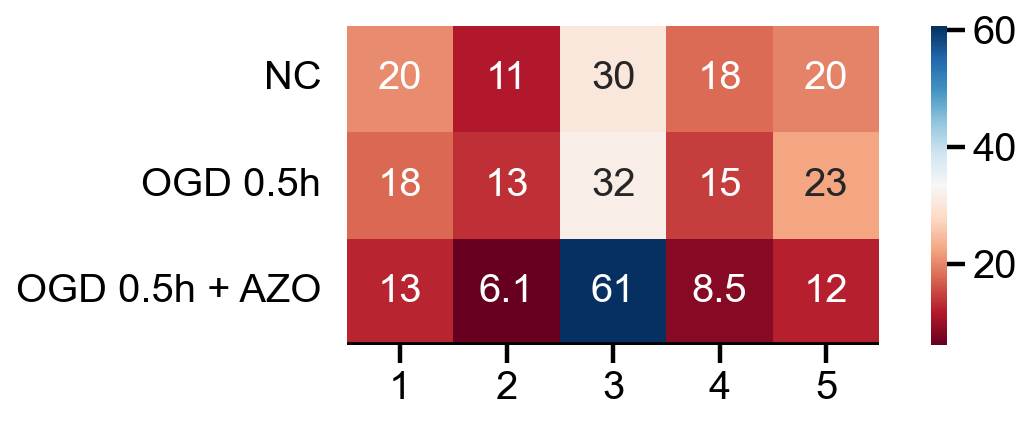

In [216]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.heatmap(
    distribution, 
    annot=True, 
    cmap='RdBu',
    yticklabels=True,
    # vmin=20-10, 
    # vmax=20+10,
    ax=ax,
    cbar=True,
    square=True,
)
ax.set_xlabel('')
ax.hlines([3], xmin=-1, xmax=5, color='k', linewidth=3)
# ax.set_yticklabels([])
ax.set_ylabel('')
ax.tick_params(left=None)
plt.tight_layout()
# plt.savefig('OGD-heatmap.png', dpi=1000)

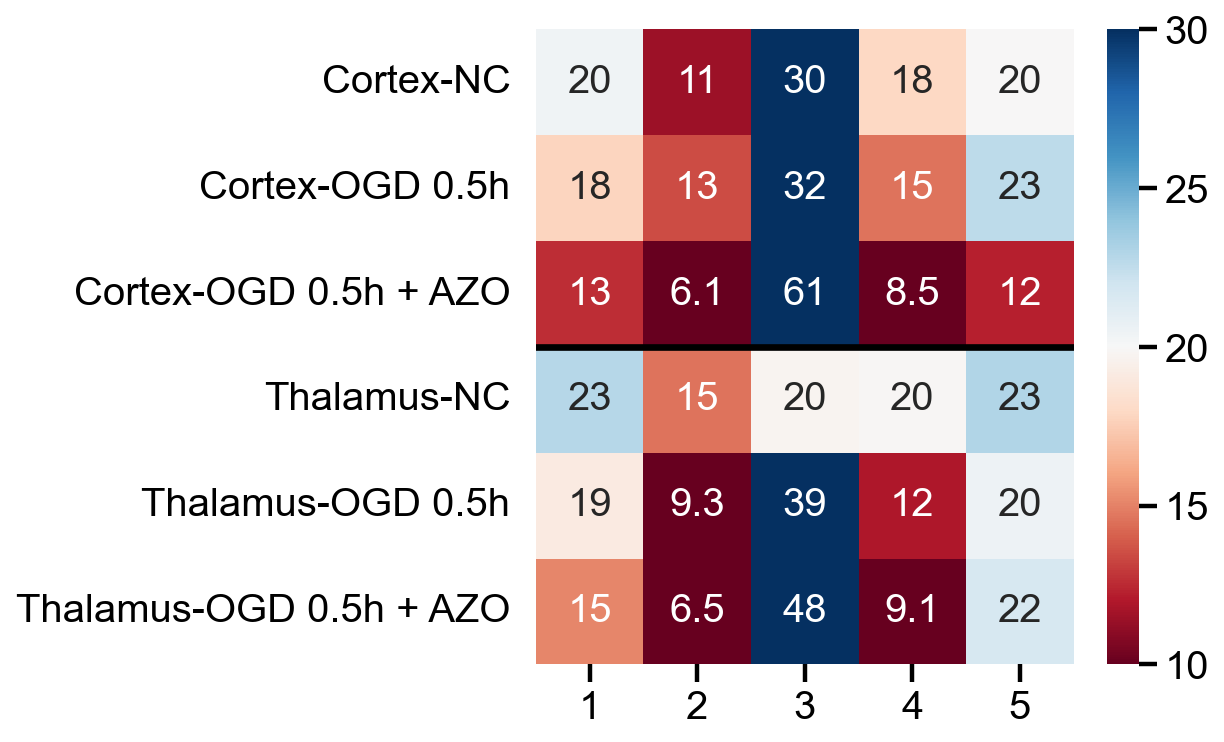

In [141]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(
    distribution, 
    annot=True, 
    cmap='RdBu',
    yticklabels=True,
    vmin=20-10, 
    vmax=20+10,
    ax=ax,
    cbar=True,
)
ax.set_xlabel('')
ax.hlines([3], xmin=-1, xmax=5, color='k', linewidth=3)
# ax.set_yticklabels([])
ax.set_ylabel('')
ax.tick_params(left=None)
plt.tight_layout()
plt.savefig('OGD-heatmap.png', dpi=1000)

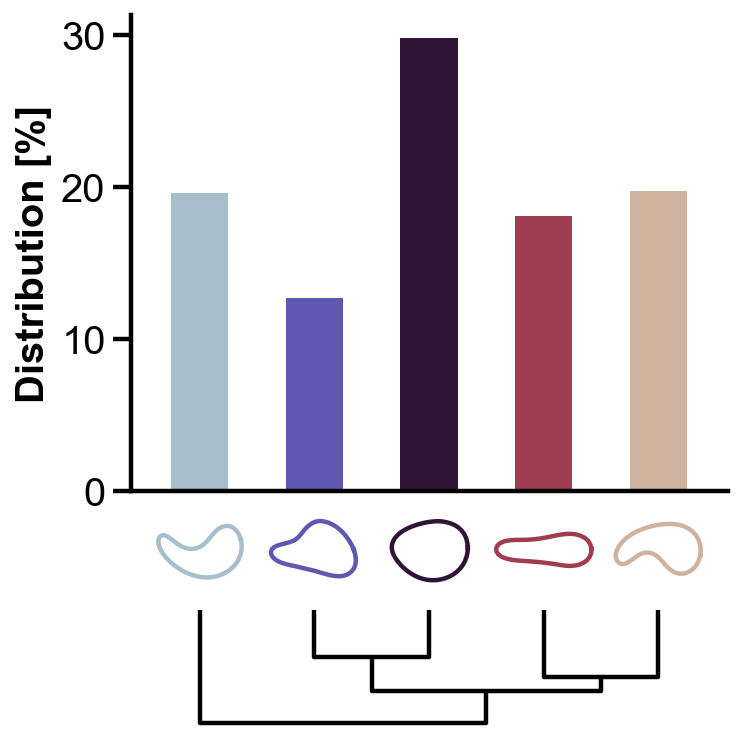

In [134]:
vp.plot.plot_distribution_contour_dendrogram(vampire_model)
plt.savefig('OGD-shape-modes.png', dpi=1000)

In [52]:
heatmap_df.groupby('treatment').count()['filename']

treatment
NC                4574
OGD 0.5h          2417
OGD 0.5h + AZO    1448
Name: filename, dtype: int64

In [53]:
heatmap_df.groupby('treatment').sum()['area']

treatment
NC                1886119
OGD 0.5h           705544
OGD 0.5h + AZO     431830
Name: area, dtype: int64

In [54]:
heatmap_df.groupby('treatment').sum()['area'] / heatmap_df.groupby('treatment').count()['filename']

treatment
NC                412.356581
OGD 0.5h          291.908978
OGD 0.5h + AZO    298.225138
dtype: float64

In [55]:
heatmap_df.groupby(['treatment', 'region']).count()['filename']

treatment       region     
NC              Cortex         1559
                Hippocampus     747
                Thalamus       2268
OGD 0.5h        Cortex          839
                Hippocampus     417
                Thalamus       1161
OGD 0.5h + AZO  Cortex         1065
                Thalamus        383
Name: filename, dtype: int64

In [56]:
heatmap_df.groupby(['treatment', 'region']).sum()['area']

treatment       region     
NC              Cortex         605347
                Hippocampus    374307
                Thalamus       906465
OGD 0.5h        Cortex         268068
                Hippocampus    107493
                Thalamus       329983
OGD 0.5h + AZO  Cortex         296420
                Thalamus       135410
Name: area, dtype: int64

In [57]:
heatmap_df.groupby(['treatment', 'region']).sum()['area'] / heatmap_df.groupby(['treatment', 'region']).count()['filename']

treatment       region     
NC              Cortex         388.291854
                Hippocampus    501.080321
                Thalamus       399.675926
OGD 0.5h        Cortex         319.508939
                Hippocampus    257.776978
                Thalamus       284.223084
OGD 0.5h + AZO  Cortex         278.328638
                Thalamus       353.550914
dtype: float64

In [58]:
heatmap_df.groupby(['treatment', 'region']).median()['area']

treatment       region     
NC              Cortex         204.0
                Hippocampus    177.0
                Thalamus       201.0
OGD 0.5h        Cortex         226.0
                Hippocampus    198.0
                Thalamus       236.0
OGD 0.5h + AZO  Cortex         179.0
                Thalamus       252.0
Name: area, dtype: float64

In [59]:
heatmap_df.groupby(['treatment']).median()['area']

treatment
NC                200.0
OGD 0.5h          224.0
OGD 0.5h + AZO    190.5
Name: area, dtype: float64

In [137]:
otsu_properties_df.shape

(20555, 32)

In [197]:
cond = otsu_properties_df['region'] == 'Cortex'
azo_treatment_df = otsu_properties_df[cond].groupby(by=['treatment', 'plot_cluster_id']).agg('median').reset_index()
azo_treatment_cond = (azo_treatment_df['treatment'].isin(['NC', 'OGD 0.5h', 'OGD 0.5h + AZO']))
azo_treatment_df = azo_treatment_df[azo_treatment_cond]
azo_treatment_df.head()

treatment  plot_cluster_id  image_id  label  centroid-y  centroid-x   area  \
0        NC                1     470.0   46.5  264.867039  261.336136  194.0   
1        NC                2     470.0   42.0  237.137615  204.056818  216.0   
2        NC                3     493.0   46.0  232.976054  252.277393  211.5   
3        NC                4     470.0   39.0  222.176966  232.615000  203.0   
4        NC                5     470.0   48.0  252.582915  269.988764  202.0   

   bbox_area  convex_area  filled_area  ...  minor_axis_length  orientation  \
0      426.0        299.5        194.0  ...          14.874367     0.033630   
1      420.0        285.0        216.0  ...          15.234269    -0.135048   
2      340.0        251.0        211.5  ...          14.998811    -0.114095   
3      484.0        307.0        203.0  ...          11.846088    -0.017007   
4      440.0        300.0        202.0  ...          14.689539    -0.155198   

   euler_number  eccentricity  solidity    extent  circularity  aspect_ratio  \
0           1.0      0.815086  0.676714  0.463391     0.327672      1.726103   
1           1.0      0.758888  0.758950  0.527778     0.435063      1.535576   
2           1.0      0.630519  0.870634  0.645833     0.680348      1.288372   
3           1.0      0.917018  0.688789  0.437654     0.337213      2.507236   
4           1.0      0.814096  0.672269  0.455556     0.342584      1.721969   

   cluster_id  distance_to_centroid  
0         0.0              0.769725  
1         1.0              0.880661  
2         2.0              0.711514  
3         3.0              0.813602  
4         4.0              0.785487  

[5 rows x 23 columns]

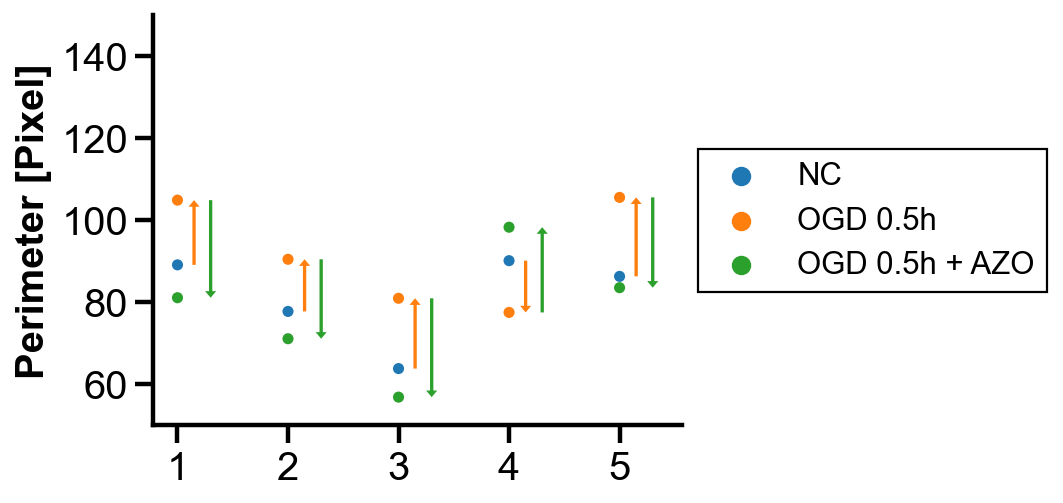

In [198]:
fig, ax = plt.subplots(figsize=(7, 3.5))
plot_change(
    df=azo_treatment_df, 
    feature='perimeter', 
    category='plot_cluster_id', 
    controlled_category='treatment', 
    init_controlled_categories=['NC', 'OGD 0.5h'], 
    final_controlled_categories=['OGD 0.5h', 'OGD 0.5h + AZO'], 
    facecolors=['tab:orange', 'tab:green'],
    ax=ax,
)
ax.set_ylim(50, 150)
ax.set_xlabel('')
ax.set_ylabel('Perimeter [Pixel]')
plt.tight_layout()
plt.savefig('OGD-perimeter-cortex.png', dpi=1000)

In [199]:
cond = otsu_properties_df['region'] == 'Thalamus'
azo_treatment_df = otsu_properties_df[cond].groupby(by=['treatment', 'plot_cluster_id']).agg('median').reset_index()
azo_treatment_cond = (azo_treatment_df['treatment'].isin(['NC', 'OGD 0.5h', 'OGD 0.5h + AZO']))
azo_treatment_df = azo_treatment_df[azo_treatment_cond]
azo_treatment_df.head()

treatment  plot_cluster_id  image_id  label  centroid-y  centroid-x   area  \
0        NC                1     473.0   55.0  264.508492  260.670302  211.0   
1        NC                2     429.0   62.5  277.637640  257.273020  200.0   
2        NC                3     335.0   63.0  261.761364  234.268371  195.0   
3        NC                4     473.0   59.0  287.959459  259.864078  187.0   
4        NC                5     473.0   55.0  253.169767  253.108431  219.5   

   bbox_area  convex_area  filled_area  ...  minor_axis_length  orientation  \
0      484.0        334.5        211.0  ...          15.738845    -0.054997   
1      416.0        298.0        200.0  ...          15.131332    -0.063938   
2      323.0        243.0        195.0  ...          14.655788    -0.123002   
3      468.0        291.0        187.0  ...          11.685790    -0.051583   
4      504.0        333.5        219.5  ...          15.705230    -0.095984   

   euler_number  eccentricity  solidity    extent  circularity  aspect_ratio  \
0           1.0      0.808756  0.634119  0.426159     0.292619      1.700264   
1           1.0      0.745474  0.695077  0.483003     0.349347      1.500320   
2           1.0      0.620884  0.833333  0.610577     0.584575      1.275670   
3           1.0      0.920838  0.626118  0.388889     0.281026      2.564464   
4           1.0      0.816598  0.639575  0.437634     0.277027      1.732482   

   cluster_id  distance_to_centroid  
0         0.0              0.796371  
1         1.0              0.888772  
2         2.0              0.795389  
3         3.0              0.814908  
4         4.0              0.795947  

[5 rows x 23 columns]

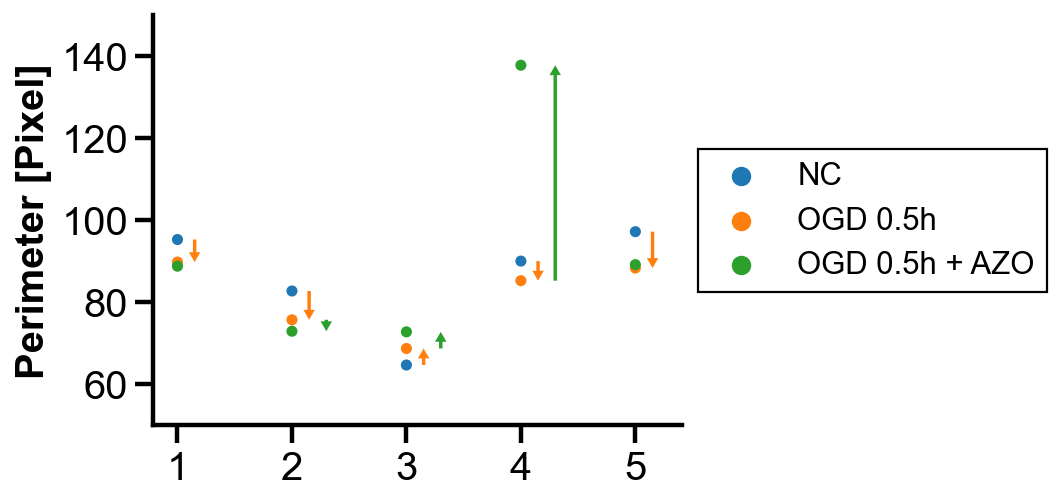

In [201]:
fig, ax = plt.subplots(figsize=(7, 3.5))
plot_change(
    df=azo_treatment_df, 
    feature='perimeter', 
    category='plot_cluster_id', 
    controlled_category='treatment', 
    init_controlled_categories=['NC', 'OGD 0.5h'], 
    final_controlled_categories=['OGD 0.5h', 'OGD 0.5h + AZO'], 
    facecolors=['tab:orange', 'tab:green'],
    ax=ax,
)
ax.set_ylim(50, 150)
ax.set_xlabel('')
ax.set_ylabel('Perimeter [Pixel]')
plt.tight_layout()
plt.savefig('OGD-perimeter-thalamus.png', dpi=1000)

In [256]:
region_cond = otsu_properties_df['region'] == 'Cortex'
treatment_cond = otsu_properties_df['treatment'].isin(['NC', 'OGD 0.5h', 'OGD 0.5h + AZO'])
heatmap_df = otsu_properties_df[treatment_cond & region_cond]
count = heatmap_df.groupby(by=['treatment', 'plot_cluster_id']).size().unstack(level=1)
distribution = count.div(count.sum(axis=1), axis=0)*100
distribution

plot_cluster_id          1          2          3          4          5
treatment                                                             
NC               20.397691  11.481719  30.275818  17.896087  19.948685
OGD 0.5h         17.759237  13.468415  31.585221  14.541120  22.646007
OGD 0.5h + AZO   12.582160   6.103286  60.657277   8.450704  12.206573

In [257]:
distribution_df = distribution.T.reset_index().melt(id_vars=['plot_cluster_id'], var_name='treatment', value_name='distribution')
distribution_df.head()

plot_cluster_id treatment  distribution
0                1        NC     20.397691
1                2        NC     11.481719
2                3        NC     30.275818
3                4        NC     17.896087
4                5        NC     19.948685

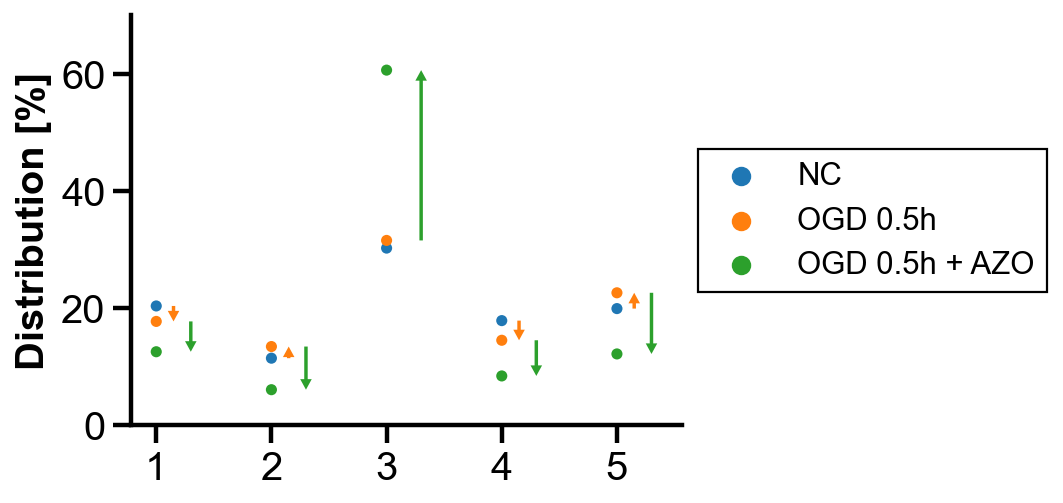

In [258]:
fig, ax = plt.subplots(figsize=(7, 3.5))
plot_change(
    df=distribution_df, 
    feature='distribution', 
    category='plot_cluster_id', 
    controlled_category='treatment', 
    init_controlled_categories=['NC', 'OGD 0.5h'], 
    final_controlled_categories=['OGD 0.5h', 'OGD 0.5h + AZO'], 
    facecolors=['tab:orange', 'tab:green'],
    ax=ax,
)
ax.set_ylim(0, 70)
ax.set_xlabel('')
ax.set_ylabel('Distribution [%]')
plt.tight_layout()
# plt.savefig('OGD-perimeter-thalamus.png', dpi=1000)

In [259]:
region_cond = otsu_properties_df['region'] == 'Thalamus'
treatment_cond = otsu_properties_df['treatment'].isin(['NC', 'OGD 0.5h', 'OGD 0.5h + AZO'])
heatmap_df = otsu_properties_df[treatment_cond & region_cond]
count = heatmap_df.groupby(by=['treatment', 'plot_cluster_id']).size().unstack(level=1)
distribution = count.div(count.sum(axis=1), axis=0)*100
distribution_df = distribution.T.reset_index().melt(id_vars=['plot_cluster_id'], var_name='treatment', value_name='distribution')

plot_cluster_id          1          2          3          4          5
treatment                                                             
NC               22.839506  14.550265  19.708995  19.885362  23.015873
OGD 0.5h         19.121447   9.302326  39.190353  11.886305  20.499569
OGD 0.5h + AZO   15.143603   6.527415  47.519582   9.138381  21.671018

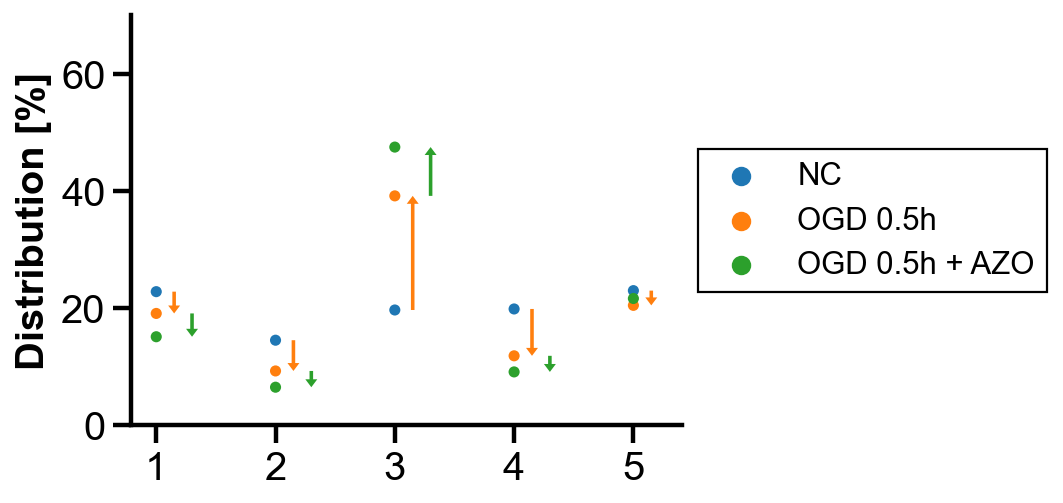

In [261]:
fig, ax = plt.subplots(figsize=(7, 3.5))
plot_change(
    df=distribution_df, 
    feature='distribution', 
    category='plot_cluster_id', 
    controlled_category='treatment', 
    init_controlled_categories=['NC', 'OGD 0.5h'], 
    final_controlled_categories=['OGD 0.5h', 'OGD 0.5h + AZO'], 
    facecolors=['tab:orange', 'tab:green'],
    ax=ax,
)
ax.set_ylim(0, 70)
ax.set_xlabel('')
ax.set_ylabel('Distribution [%]')
plt.tight_layout()
# plt.savefig('OGD-perimeter-thalamus.png', dpi=1000)

In [286]:
region_cond = otsu_properties_df['region'] == 'Cortex'
treatment_cond = otsu_properties_df['treatment'].isin(['NC', 'OGD 0.5h', 'OGD 0.5h + AZO'])
heatmap_df = otsu_properties_df[treatment_cond & region_cond]
count = heatmap_df.groupby(by=['treatment', 'plot_cluster_id']).size().unstack(level=1)
distribution = count.div(count.sum(axis=1), axis=0)*100
cortex_distribution_df = distribution.T.reset_index().melt(id_vars=['plot_cluster_id'], var_name='treatment', value_name='distribution')

region_cond = otsu_properties_df['region'] == 'Thalamus'
treatment_cond = otsu_properties_df['treatment'].isin(['NC', 'OGD 0.5h', 'OGD 0.5h + AZO'])
heatmap_df = otsu_properties_df[treatment_cond & region_cond]
count = heatmap_df.groupby(by=['treatment', 'plot_cluster_id']).size().unstack(level=1)
distribution = count.div(count.sum(axis=1), axis=0)*100
thalamus_distribution_df = distribution.T.reset_index().melt(id_vars=['plot_cluster_id'], var_name='treatment', value_name='distribution')

cond = otsu_properties_df['region'] == 'Cortex'
azo_treatment_df = otsu_properties_df[cond].groupby(by=['treatment', 'plot_cluster_id']).agg('median').reset_index()
azo_treatment_cond = (azo_treatment_df['treatment'].isin(['NC', 'OGD 0.5h', 'OGD 0.5h + AZO']))
cortex_azo_treatment_df = azo_treatment_df[azo_treatment_cond]

cond = otsu_properties_df['region'] == 'Thalamus'
azo_treatment_df = otsu_properties_df[cond].groupby(by=['treatment', 'plot_cluster_id']).agg('median').reset_index()
azo_treatment_cond = (azo_treatment_df['treatment'].isin(['NC', 'OGD 0.5h', 'OGD 0.5h + AZO']))
thalamus_azo_treatment_df = azo_treatment_df[azo_treatment_cond]

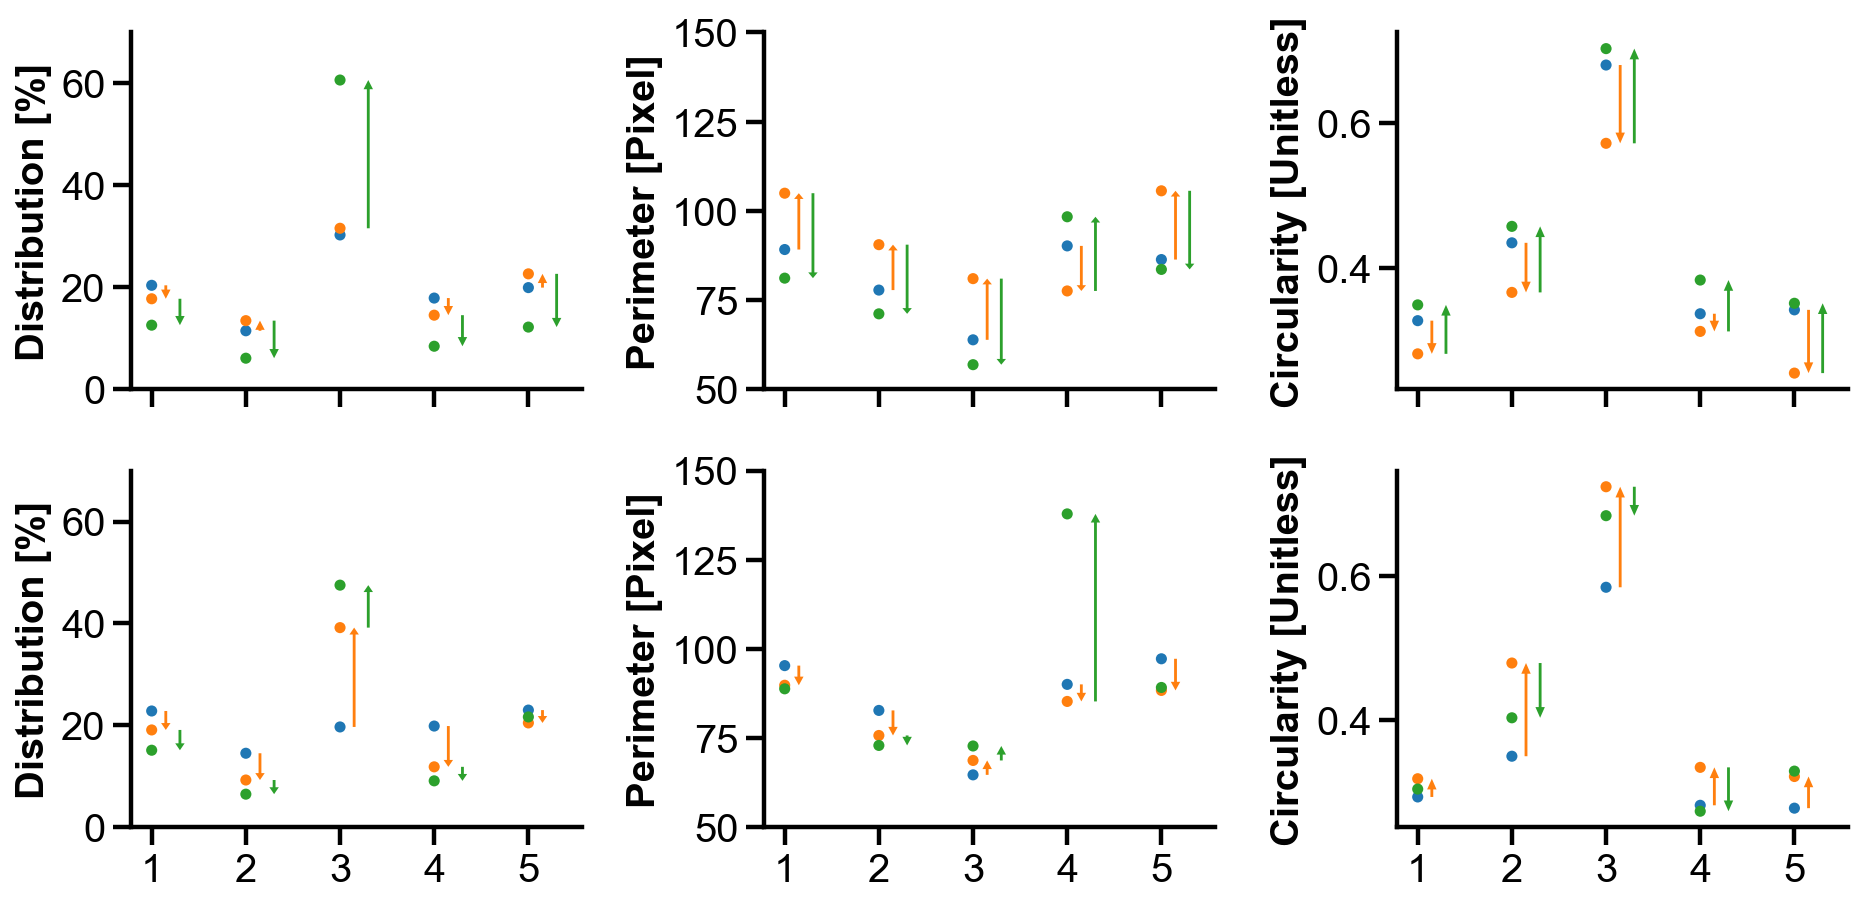

In [293]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6), sharex=True)
plot_change(
    df=cortex_distribution_df, 
    feature='distribution', 
    category='plot_cluster_id', 
    controlled_category='treatment', 
    init_controlled_categories=['NC', 'OGD 0.5h'], 
    final_controlled_categories=['OGD 0.5h', 'OGD 0.5h + AZO'], 
    facecolors=['tab:orange', 'tab:green'],
    ax=axs[0, 0],
)
plot_change(
    df=thalamus_distribution_df, 
    feature='distribution', 
    category='plot_cluster_id', 
    controlled_category='treatment', 
    init_controlled_categories=['NC', 'OGD 0.5h'], 
    final_controlled_categories=['OGD 0.5h', 'OGD 0.5h + AZO'], 
    facecolors=['tab:orange', 'tab:green'],
    ax=axs[1, 0],
)
j = 0
for i in range(2):
    axs[i, j].set_ylim(0, 70)
    axs[i, j].set_xlabel('')
    axs[i, j].set_ylabel('Distribution [%]')
    axs[i, j].get_legend().remove()

plot_change(
    df=cortex_azo_treatment_df, 
    feature='perimeter', 
    category='plot_cluster_id', 
    controlled_category='treatment', 
    init_controlled_categories=['NC', 'OGD 0.5h'], 
    final_controlled_categories=['OGD 0.5h', 'OGD 0.5h + AZO'], 
    facecolors=['tab:orange', 'tab:green'],
    ax=axs[0, 1],
)
plot_change(
    df=thalamus_azo_treatment_df, 
    feature='perimeter', 
    category='plot_cluster_id', 
    controlled_category='treatment', 
    init_controlled_categories=['NC', 'OGD 0.5h'], 
    final_controlled_categories=['OGD 0.5h', 'OGD 0.5h + AZO'], 
    facecolors=['tab:orange', 'tab:green'],
    ax=axs[1, 1],
)
    
j = 1
for i in range(2):
    axs[i, j].set_ylim(50, 150)
    axs[i, j].set_xlabel('')
    axs[i, j].set_ylabel('Perimeter [Pixel]')
    axs[i, j].get_legend().remove()
    
plot_change(
    df=cortex_azo_treatment_df, 
    feature='circularity', 
    category='plot_cluster_id', 
    controlled_category='treatment', 
    init_controlled_categories=['NC', 'OGD 0.5h'], 
    final_controlled_categories=['OGD 0.5h', 'OGD 0.5h + AZO'], 
    facecolors=['tab:orange', 'tab:green'],
    ax=axs[0, 2],
)
plot_change(
    df=thalamus_azo_treatment_df, 
    feature='circularity', 
    category='plot_cluster_id', 
    controlled_category='treatment', 
    init_controlled_categories=['NC', 'OGD 0.5h'], 
    final_controlled_categories=['OGD 0.5h', 'OGD 0.5h + AZO'], 
    facecolors=['tab:orange', 'tab:green'],
    ax=axs[1, 2],
)
    
j = 2
for i in range(2):
    # axs[i, j].set_ylim(50, 150)
    axs[i, j].set_xlabel('')
    axs[i, j].set_ylabel('Circularity [Unitless]')
    axs[i, j].get_legend().remove()

plt.tight_layout()
# plt.savefig('OGD-perimeter-thalamus.png', dpi=1000)

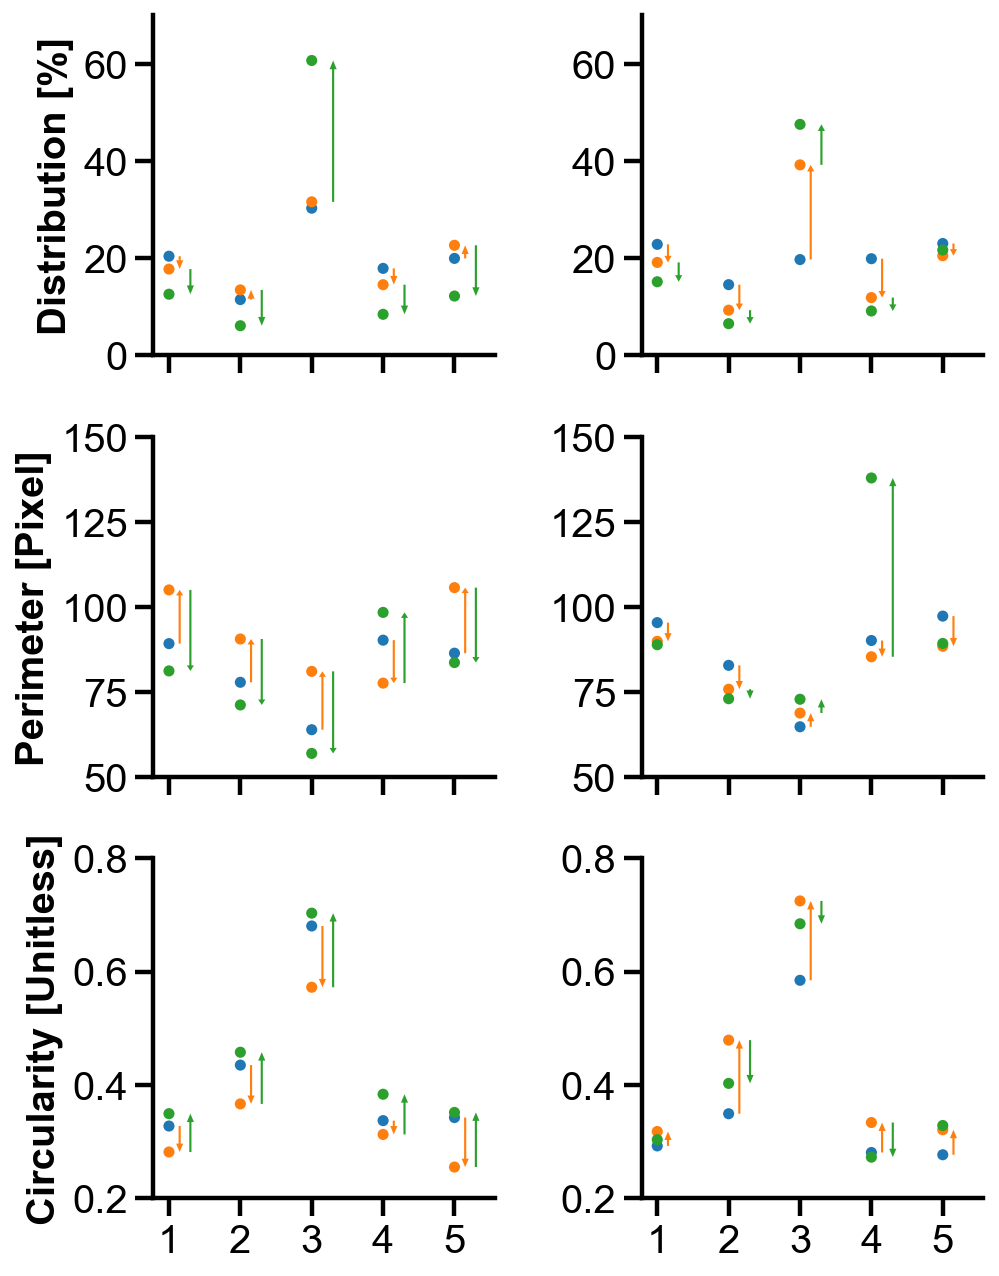

In [309]:
fig, axs = plt.subplots(3, 2, figsize=(8/1.2, 10/1.2), sharex=True)
plot_change(
    df=cortex_distribution_df, 
    feature='distribution', 
    category='plot_cluster_id', 
    controlled_category='treatment', 
    init_controlled_categories=['NC', 'OGD 0.5h'], 
    final_controlled_categories=['OGD 0.5h', 'OGD 0.5h + AZO'], 
    facecolors=['tab:orange', 'tab:green'],
    ax=axs[0, 0],
)
plot_change(
    df=thalamus_distribution_df, 
    feature='distribution', 
    category='plot_cluster_id', 
    controlled_category='treatment', 
    init_controlled_categories=['NC', 'OGD 0.5h'], 
    final_controlled_categories=['OGD 0.5h', 'OGD 0.5h + AZO'], 
    facecolors=['tab:orange', 'tab:green'],
    ax=axs[0, 1],
)
i = 0
for j in range(2):
    axs[i, j].set_ylim(0, 70)
    axs[i, j].set_xlabel('')
    axs[i, j].set_ylabel('Distribution [%]')
    axs[i, j].get_legend().remove()
axs[i, 1].set_ylabel(None)

plot_change(
    df=cortex_azo_treatment_df, 
    feature='perimeter', 
    category='plot_cluster_id', 
    controlled_category='treatment', 
    init_controlled_categories=['NC', 'OGD 0.5h'], 
    final_controlled_categories=['OGD 0.5h', 'OGD 0.5h + AZO'], 
    facecolors=['tab:orange', 'tab:green'],
    ax=axs[1, 0],
)
plot_change(
    df=thalamus_azo_treatment_df, 
    feature='perimeter', 
    category='plot_cluster_id', 
    controlled_category='treatment', 
    init_controlled_categories=['NC', 'OGD 0.5h'], 
    final_controlled_categories=['OGD 0.5h', 'OGD 0.5h + AZO'], 
    facecolors=['tab:orange', 'tab:green'],
    ax=axs[1, 1],
)
    
i = 1
for j in range(2):
    axs[i, j].set_ylim(50, 150)
    axs[i, j].set_xlabel('')
    axs[i, j].set_ylabel('Perimeter [Pixel]')
    axs[i, j].get_legend().remove()
axs[i, 1].set_ylabel(None)

plot_change(
    df=cortex_azo_treatment_df, 
    feature='circularity', 
    category='plot_cluster_id', 
    controlled_category='treatment', 
    init_controlled_categories=['NC', 'OGD 0.5h'], 
    final_controlled_categories=['OGD 0.5h', 'OGD 0.5h + AZO'], 
    facecolors=['tab:orange', 'tab:green'],
    ax=axs[2, 0],
)
plot_change(
    df=thalamus_azo_treatment_df, 
    feature='circularity', 
    category='plot_cluster_id', 
    controlled_category='treatment', 
    init_controlled_categories=['NC', 'OGD 0.5h'], 
    final_controlled_categories=['OGD 0.5h', 'OGD 0.5h + AZO'], 
    facecolors=['tab:orange', 'tab:green'],
    ax=axs[2, 1],
)
    
i = 2
for j in range(2):
    axs[i, j].set_ylim(0.2, 0.8)
    axs[i, j].set_xlabel('')
    axs[i, j].set_ylabel('Circularity [Unitless]')
    axs[i, j].get_legend().remove()
axs[i, 1].set_ylabel(None)

plt.tight_layout()
plt.savefig('OGD-region-variation.png', dpi=1000)

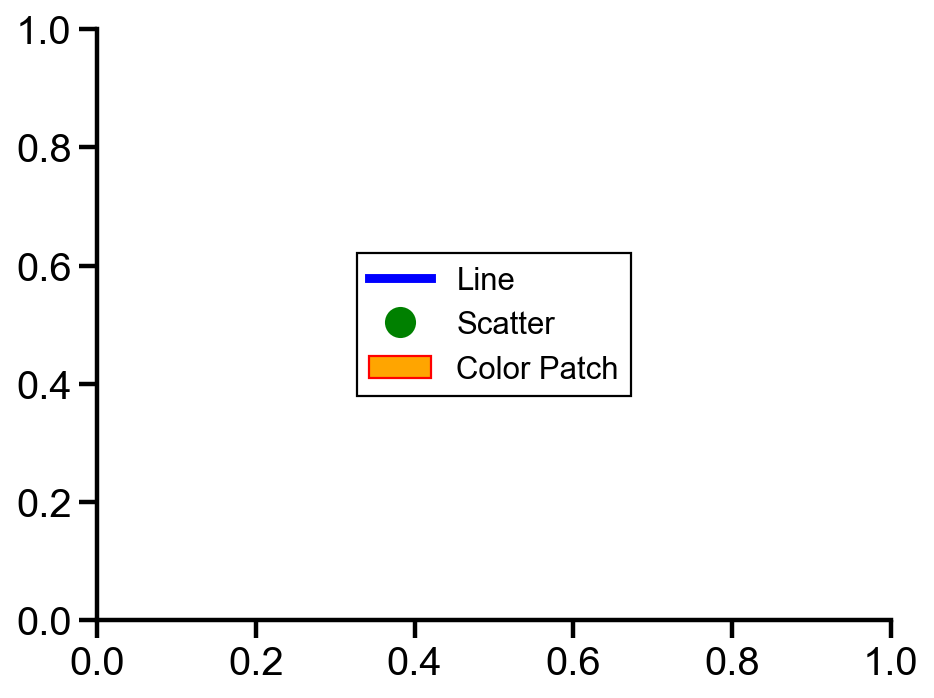

In [310]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

legend_elements = [
    Line2D([0], [0], color='b', lw=4, label='Line'),
                   Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='g', markersize=15),
                   Patch(facecolor='orange', edgecolor='r',
                         label='Color Patch')]

# Create the figure
fig, ax = plt.subplots()
ax.legend(handles=legend_elements, loc='center')


plt.show()